***IMPORTING LIBRARIES***

In [ ]:
# Importing Data Analysis Libraries
import pandas as pd
import numpy as np

# Normalize Dataset
from sklearn.preprocessing import MinMaxScaler

# Splitting Data into train set and Test set
from sklearn.model_selection import train_test_split

# Importing Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("darkgrid")

# Python drawing
from IPython.core.pylabtools import figsize

# Importing Tensorflow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger # Generating Model logs
from tensorflow.keras.utils import plot_model


# Model Evaluation
from sklearn.metrics import r2_score

# Convert Object to Datetime and display in matplotlib without casting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

***DEFINING GLOBAL VARIABLES AND FUNCTIONS FOR CODE REUSE***

In [ ]:
# Creating directory for saving log and model.
!mkdir -p saved_data

# CSVLogger variable for generating model logs
csv_logger = CSVLogger('saved_data/training.log', ',', append=True)

# Future close variable
next_close = 'FUTURE_CLOSE'

# Hyperparameter for data transformation
TIME_STEPS = 10

# Number of neurons used
total_units = 64

# FUNCTION TO PLOT A FIGURE OBJECT
legend_loc= 'upper left'
def plot_figure(xlabel, ylabel, title, legend_loc):
    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.title(title)
    plt.legend(loc=legend_loc)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return plt

***IMPORTING DATA***

In [ ]:
# Fetching the csv dataset from GitHub repository
crypto_dataframe = pd.read_csv("https://raw.githubusercontent.com/247pankaj/crypto-dataset/main/Bitcoin_price.csv")

In [ ]:
# Printing the last 5 records in dataset
crypto_dataframe.tail()

,Date,Open,High,Low,Close,Volume,MarketCap
2811,08-Jan-21,39381.77,41946.74,36838.64,40797.61,8.810752e+10,7.590000e+11
2812,09-Jan-21,40788.64,41436.35,38980.88,40254.55,6.198416e+10,7.490000e+11
2813,10-Jan-21,40254.22,41420.19,35984.63,38356.44,7.998075e+10,7.130000e+11
2814,11-Jan-21,38346.53,38346.53,30549.60,35566.66,1.233210e+11,6.614570e+11
2815,12-Jan-21,35516.36,36568.53,32697.98,33922.96,7.477328e+10,6.309200e+11


In [ ]:
# Feature DataTypes
crypto_dataframe.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
MarketCap    float64
dtype: object

***DATA PREPROCESSING***

In [ ]:
# Converting Date Object into Datetime
crypto_dataframe['Date'] = crypto_dataframe['Date'].astype('datetime64[ns]')

No handles with labels found to put in legend.


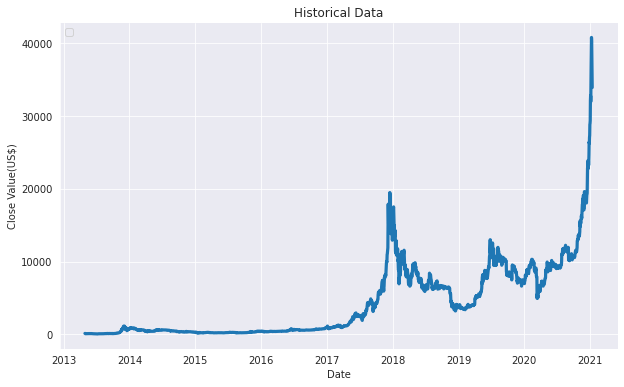

In [ ]:
# Plotting the dataset
plot_fig = plot_figure("Date", "Close Value(US$)", "Historical Data", legend_loc) #plot_figure(xlabel, ylabel, title, legend_loc)
sns.set_context("paper", font_scale=2.1, rc={"lines.linewidth": 3.2})
sns.lineplot(data=crypto_dataframe, x="Date", y="Close")
horizontalalignment='center'
sns.despine()

In [ ]:
crypto_dataframe[next_close] = crypto_dataframe['Close'].shift(-1,fill_value=0)

In [ ]:
crypto_dataframe.drop(crypto_dataframe.tail(1).index,inplace=True)

In [ ]:
crypto_dataframe = crypto_dataframe.drop(columns=['Close'])

In [ ]:
crypto_dataframe = crypto_dataframe.set_index('Date')

In [ ]:
crypto_dataframe.tail()

,Open,High,Low,Volume,MarketCap,FUTURE_CLOSE
Date,,,,,,
2021-01-07,36833.87,40180.37,36491.19,8.476214e+10,7.320000e+11,40797.61
2021-01-08,39381.77,41946.74,36838.64,8.810752e+10,7.590000e+11,40254.55
2021-01-09,40788.64,41436.35,38980.88,6.198416e+10,7.490000e+11,38356.44
2021-01-10,40254.22,41420.19,35984.63,7.998075e+10,7.130000e+11,35566.66
2021-01-11,38346.53,38346.53,30549.60,1.233210e+11,6.614570e+11,33922.96


In [ ]:
# Train-Test Split(80%-20%)
training_size = int(len(crypto_dataframe) * 0.80)
training_dataset, testing_dataset = crypto_dataframe.iloc[:training_size],crypto_dataframe.iloc[training_size:]

No handles with labels found to put in legend.


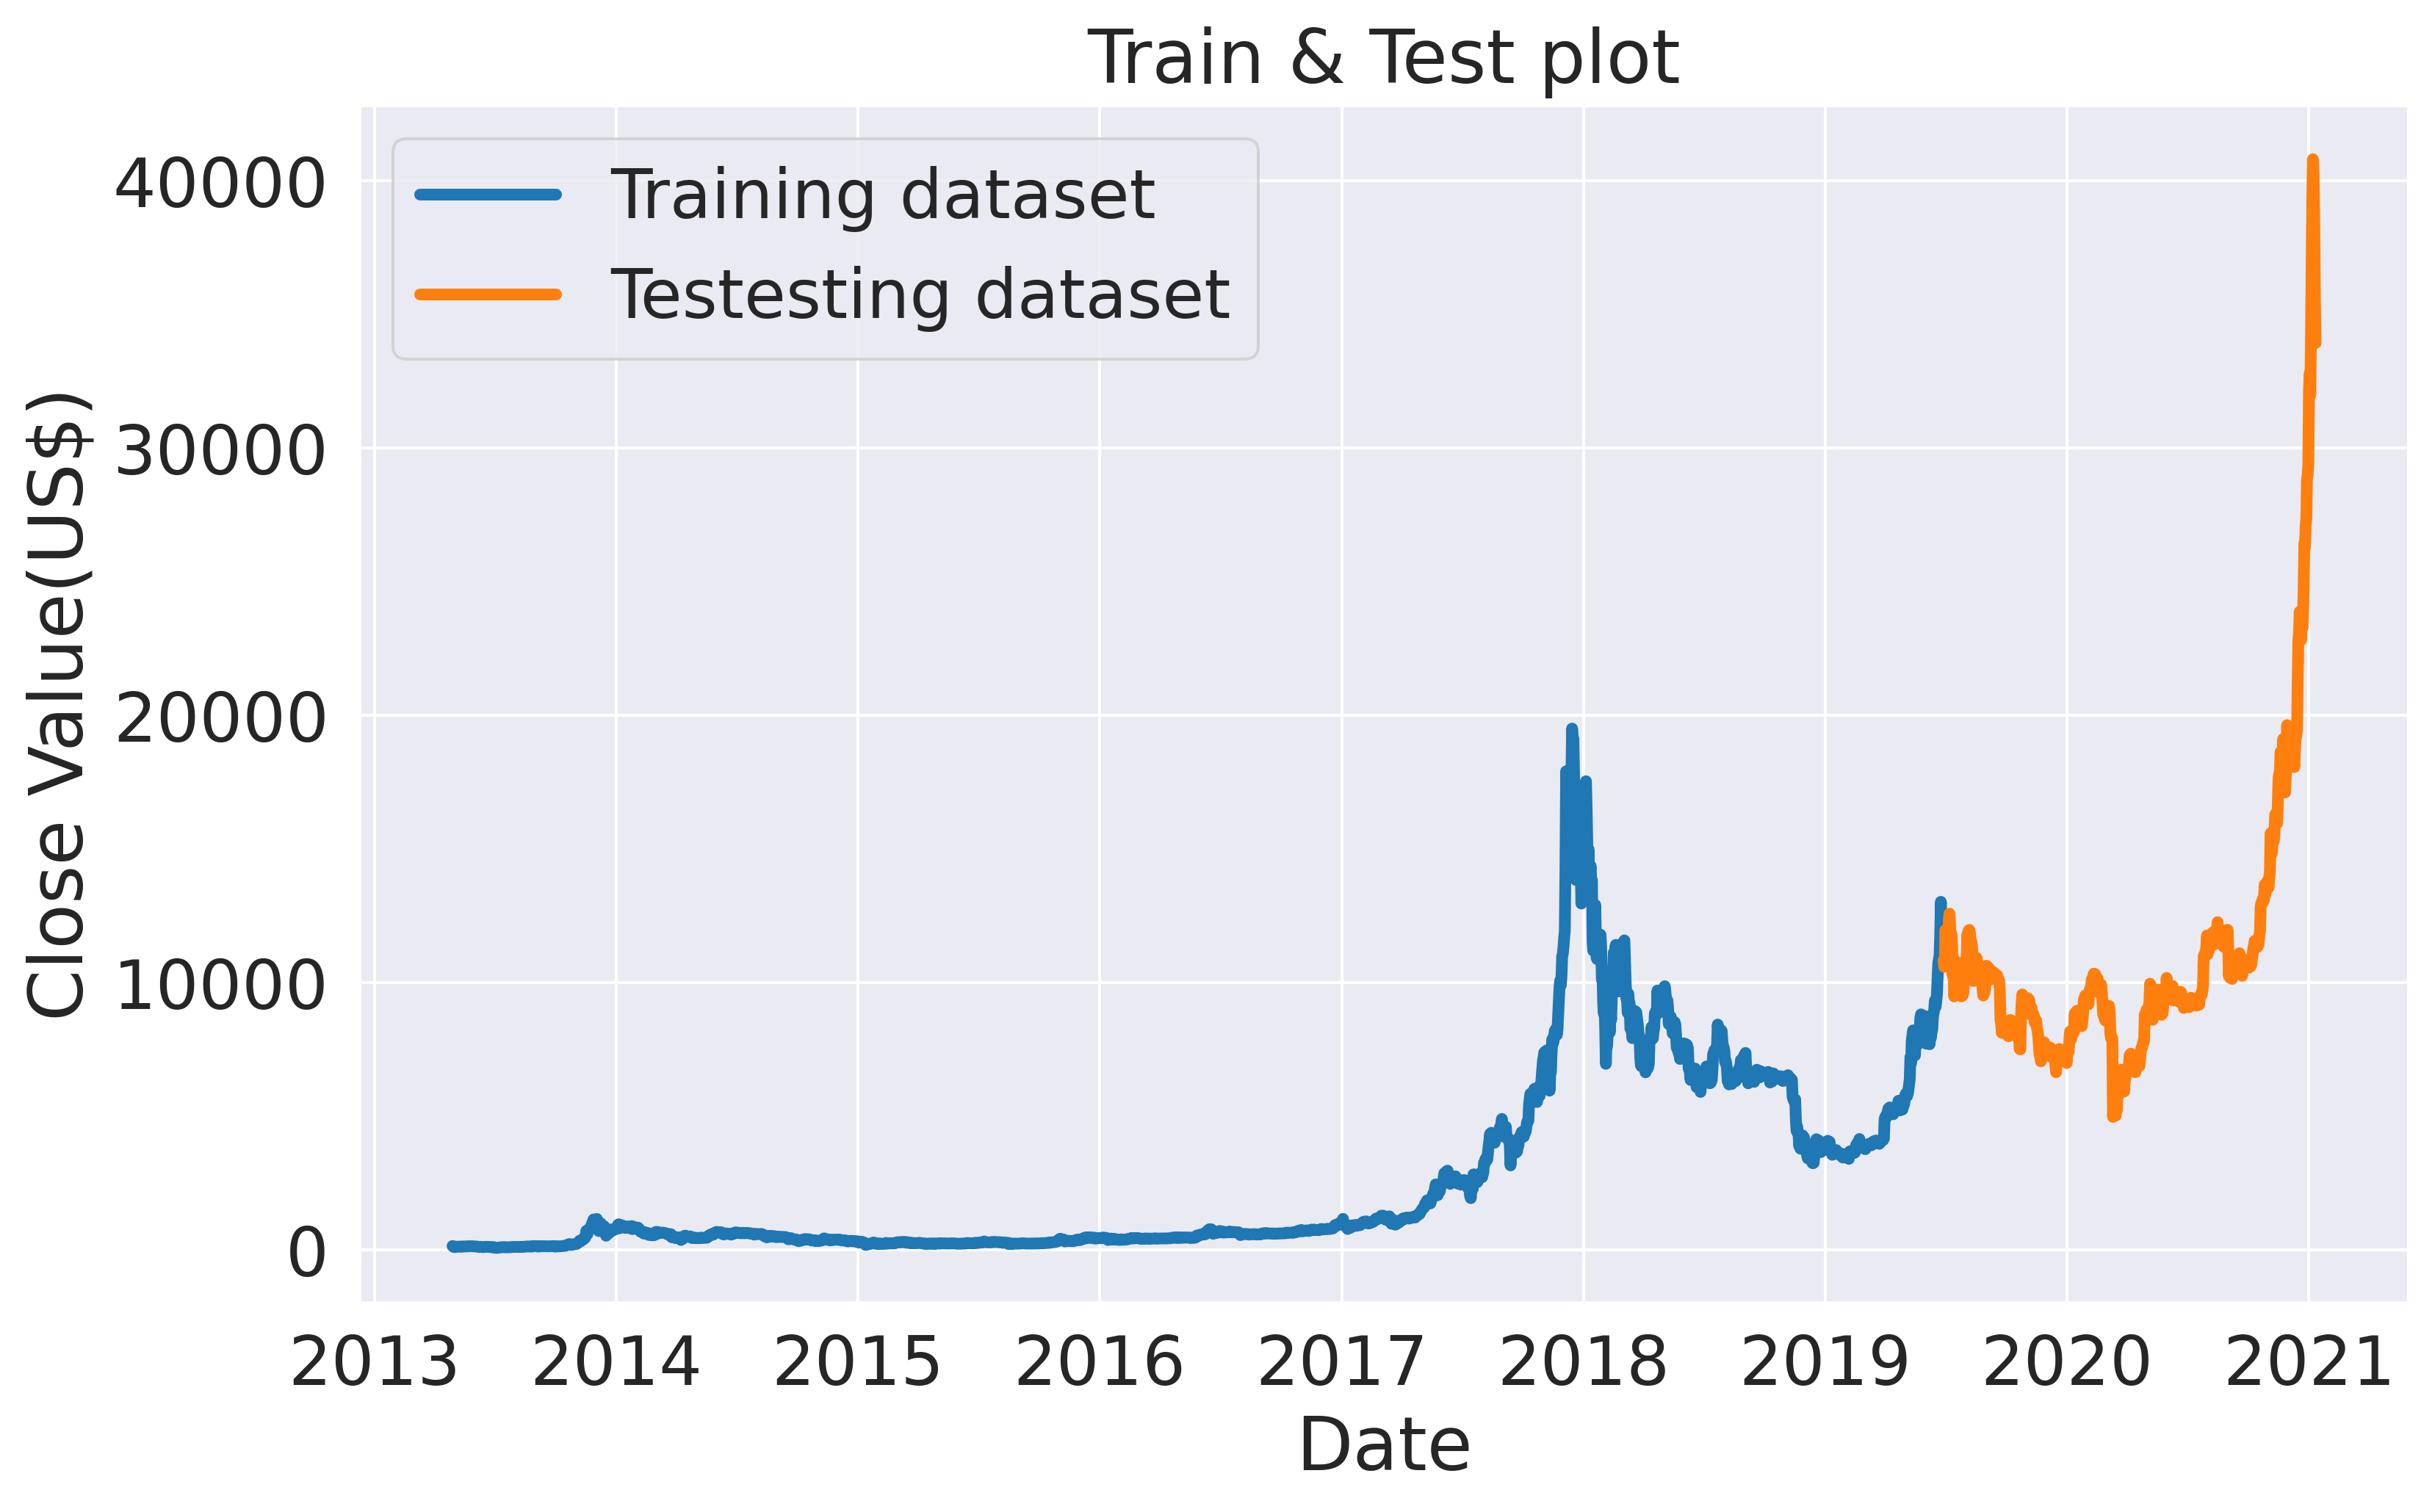

In [ ]:
plt_fig = plot_figure("Date", "Close Value(US$)", "Train & Test plot", legend_loc) #plot_figure(xlabel, ylabel, title, legend_loc)

plt_fig.plot(training_dataset.FUTURE_CLOSE)
plt_fig.plot(testing_dataset.FUTURE_CLOSE)
plt_fig.legend(['Training dataset', 'Testesting dataset'], loc='upper left')


In [ ]:
# Splitting training_dataset into Predictors and outcomes
X_train = training_dataset.drop(next_close, axis = 1)
y_train = training_dataset.loc[:,[next_close]]

# Splitting testing_dataset into Predictors and outcomes
X_test = testing_dataset.drop(next_close, axis = 1)
y_test = testing_dataset.loc[:,[next_close]]

In [ ]:
min_max_scaler = MinMaxScaler(feature_range = (-1,1))

# Fitting MinMaxScaler to Trainset(X_train,y_train)
predictor_scaler = min_max_scaler.fit(X_train)
outcome_scaler = min_max_scaler.fit(y_train)

# Scaler in trainset
y_norm_train = outcome_scaler.transform(y_train)
x_norm_train = predictor_scaler.transform(X_train)

# Scaler in testset
y_norm_test = outcome_scaler.transform(y_test)
x_norm_test = predictor_scaler.transform(X_test)

***DATA TRANSFORMATION***

In [ ]:
def transform_dataset (X_array, y_array, time_steps = 1):
    X_transform, y_transform = [], []
    for i in range(len(X_array) - time_steps):
        output = X_array[i:i+time_steps, :]
        X_transform.append(output)
        y_transform.append(y_array[i+time_steps])

    return np.array(X_transform), np.array(y_transform)


X_test, y_test = transform_dataset(x_norm_test, y_norm_test, TIME_STEPS)
X_train, y_train = transform_dataset(x_norm_train, y_norm_train, TIME_STEPS)

print('X_train: ', X_train)

X_train:  [[[-9.93204992e-01 -9.91861638e-01 -9.93250286e-01 -1.00704412e+00
    1.65089460e+05]
  [-9.92220895e-01 -9.91919283e-01 -9.93245139e-01 -1.00704412e+00
    1.58814733e+05]
  [-9.92735590e-01 -9.92643974e-01 -9.95955524e-01 -1.00704412e+00
    1.33712164e+05]
  ...
  [-9.95105247e-01 -9.94211736e-01 -9.96066698e-01 -1.00704412e+00
    1.28572259e+05]
  [-9.95489210e-01 -9.95366713e-01 -9.96986974e-01 -1.00704412e+00
    1.27704538e+05]
  [-9.95761999e-01 -9.95125835e-01 -9.95761999e-01 -1.00704412e+00
    1.30119036e+05]]

 [[-9.92220895e-01 -9.91919283e-01 -9.93245139e-01 -1.00704412e+00
    1.58814733e+05]
  [-9.92735590e-01 -9.92643974e-01 -9.95955524e-01 -1.00704412e+00
    1.33712164e+05]
  [-9.95064072e-01 -9.94114974e-01 -9.97544903e-01 -1.00704412e+00
    1.20285091e+05]
  ...
  [-9.95489210e-01 -9.95366713e-01 -9.96986974e-01 -1.00704412e+00
    1.27704538e+05]
  [-9.95761999e-01 -9.95125835e-01 -9.95761999e-01 -1.00704412e+00
    1.30119036e+05]
  [-9.95391418e-01 

***DATA MODELING***

*   Model Creation
*   Model Training
*   Hyperparameter Tune
*   Sequential and parallel architecture implementation

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          27264       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          27264       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][0]              
                                                                 bidirectional_1[0][0]        

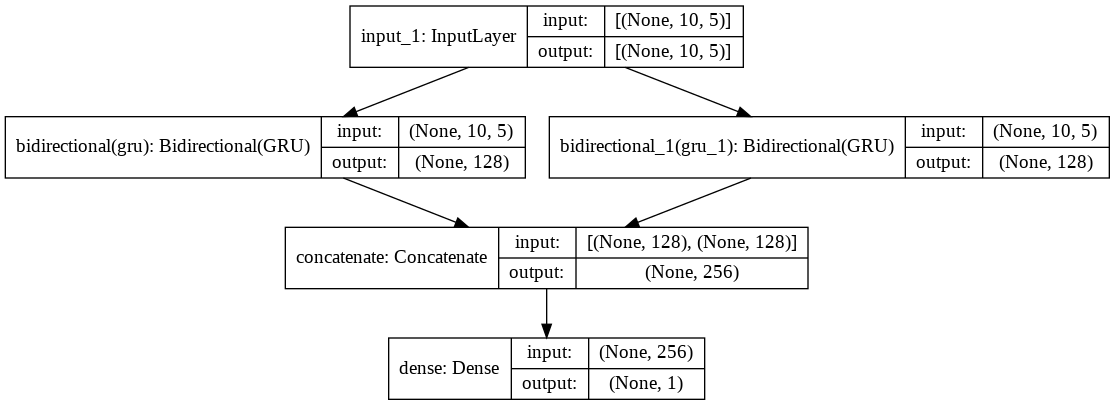

In [ ]:
# BiRNN Model using Functional API of Keras (Parallel)

def build_model_birnn_func(units, mt):
    input1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden1 = Bidirectional(mt(units = units) )(input1)

    hidden2 = Bidirectional(mt(units = units))(input1)

    hidden3 = keras.layers.concatenate([hidden1, hidden2]) # Concat
    output = Dense(1)(hidden3)

    parallelModel = Model(inputs=input1, outputs=output)

    parallelModel.compile(optimizer='adam',loss='mse')
    return parallelModel

# Building the Sequential Bidirectional model
def build_model_birnn(units, mt):
    sequentialModel = Sequential()
    sequentialModel.add(Bidirectional(mt(units), input_shape=(X_train.shape[1], X_train.shape[2])))
    sequentialModel.add(Dense(1))

    sequentialModel.compile(optimizer='adam',loss='mse')
    return sequentialModel


# Building LSTM or GRU Sequential model
def build_model_sequential(units, mt):
    sequentialModel = Sequential()
    sequentialModel.add(mt(units,  input_shape=(X_train.shape[1], X_train.shape[2])))
    sequentialModel.add(Dense(1))
    sequentialModel.compile(optimizer='adam',loss='mse')

    return sequentialModel

# Functional API BiRNN
func_biGruModel = build_model_birnn_func(total_units, GRU)
func_biLstmModel = build_model_birnn_func(total_units, LSTM)


# BiRNN Sequential GRU and LSTM
biGruModel = build_model_birnn(total_units, GRU)
biLstmModel = build_model_birnn(total_units, LSTM)


# GRU and LSTM Sequential
gruModel = build_model_sequential(total_units, GRU)
lstmModel = build_model_sequential(total_units, LSTM)


# Model summary and plot
func_biGruModel.summary()
plot_model(func_biGruModel, to_file='saved_data/func_biGruModel.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128)          35840       input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 128)          35840       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           bidirectional_2[0][0]            
                                                                 bidirectional_3[0][0]      

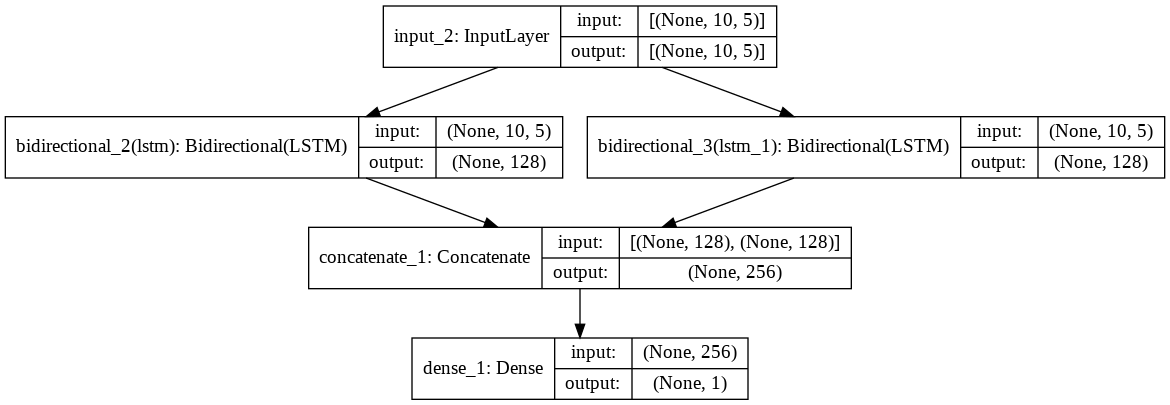

In [ ]:
func_biLstmModel.summary()
plot_model(func_biLstmModel, to_file='saved_data/func_biLstmModel.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 128)               27264     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 27,393
Trainable params: 27,393
Non-trainable params: 0
_________________________________________________________________


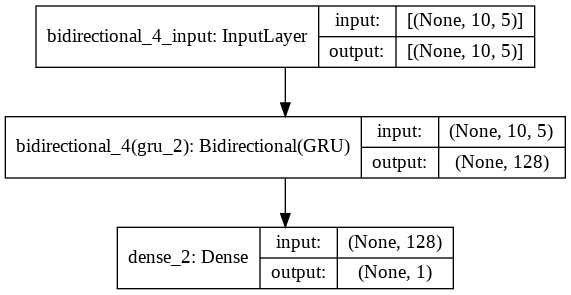

In [ ]:
biGruModel.summary()
plot_model(biGruModel, to_file='saved_data/biGruModel.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 128)               35840     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 35,969
Trainable params: 35,969
Non-trainable params: 0
_________________________________________________________________


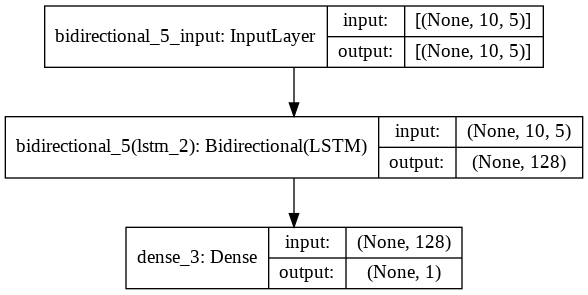

In [ ]:
biLstmModel.summary()
plot_model(biLstmModel, to_file='saved_data/biLstmModel.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 64)                13632     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


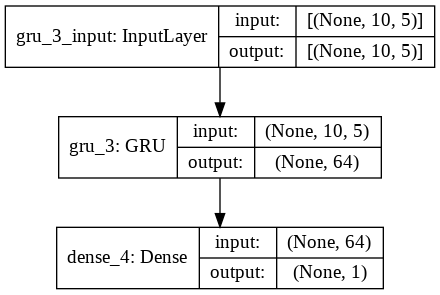

In [ ]:
gruModel.summary()
plot_model(gruModel, to_file='saved_data/gruModel.png', show_shapes=True, show_layer_names=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


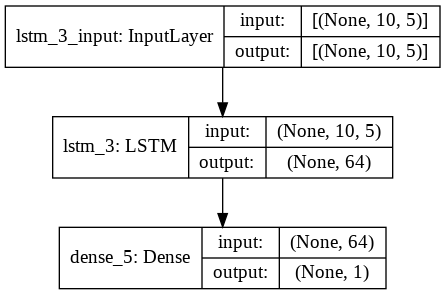

In [ ]:
lstmModel.summary()
plot_model(lstmModel, to_file='saved_data/lstmModel.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Existing models Fit function
def fit_mType(mType):
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    modelHistory = mType.fit(X_train, y_train, epochs = 10, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [csv_logger,early_stopping])
    return modelHistory

#Fitting all 6 models created above
parallel_biGru_history = fit_mType(func_biGruModel)
parallel_biLstm_history = fit_mType(func_biLstmModel)

sequential_biGru_history = fit_mType(biGruModel)
sequential_biLstm_history = fit_mType(biLstmModel)

sequential_gru_history = fit_mType(gruModel)
sequential_lstm_history = fit_mType(lstmModel)

Epoch 1/10
57/57 [==============================] - 9s 47ms/step - loss: 0.0463 - val_loss: 0.8509
Epoch 2/10
57/57 [==============================] - 1s 21ms/step - loss: 0.1257 - val_loss: 0.6981
Epoch 3/10
57/57 [==============================] - 1s 22ms/step - loss: 0.1095 - val_loss: 0.6987
Epoch 4/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0972 - val_loss: 0.7376
Epoch 5/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0897 - val_loss: 0.7814
Epoch 6/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0841 - val_loss: 0.8234
Epoch 7/10
57/57 [==============================] - 1s 20ms/step - loss: 0.0795 - val_loss: 0.8621
Epoch 8/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0757 - val_loss: 0.8967
Epoch 9/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0725 - val_loss: 0.9271
Epoch 10/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0698 - val_loss: 0.9534
Epoch 1/1

In [ ]:
y_test = min_max_scaler.inverse_transform(y_test)
y_train = min_max_scaler.inverse_transform(y_train)

pred = gruModel.predict(X_test)
pred.shape

(553, 1)

In [ ]:
# Prediction
def perform_prediction(mType):
    predict_values = mType.predict(X_test)
    predict_values = min_max_scaler.inverse_transform(predict_values)
    return predict_values

predicted_parallel_biGru = perform_prediction(func_biGruModel)
predicted_parallel_biLstm = perform_prediction(func_biLstmModel)

predicted_sequential_biGru = perform_prediction(biGruModel)
predicted_sequential_biLstm = perform_prediction(biLstmModel)

predicted_sequential_Gru = perform_prediction(gruModel)
predicted_sequential_Lstm = perform_prediction(lstmModel)

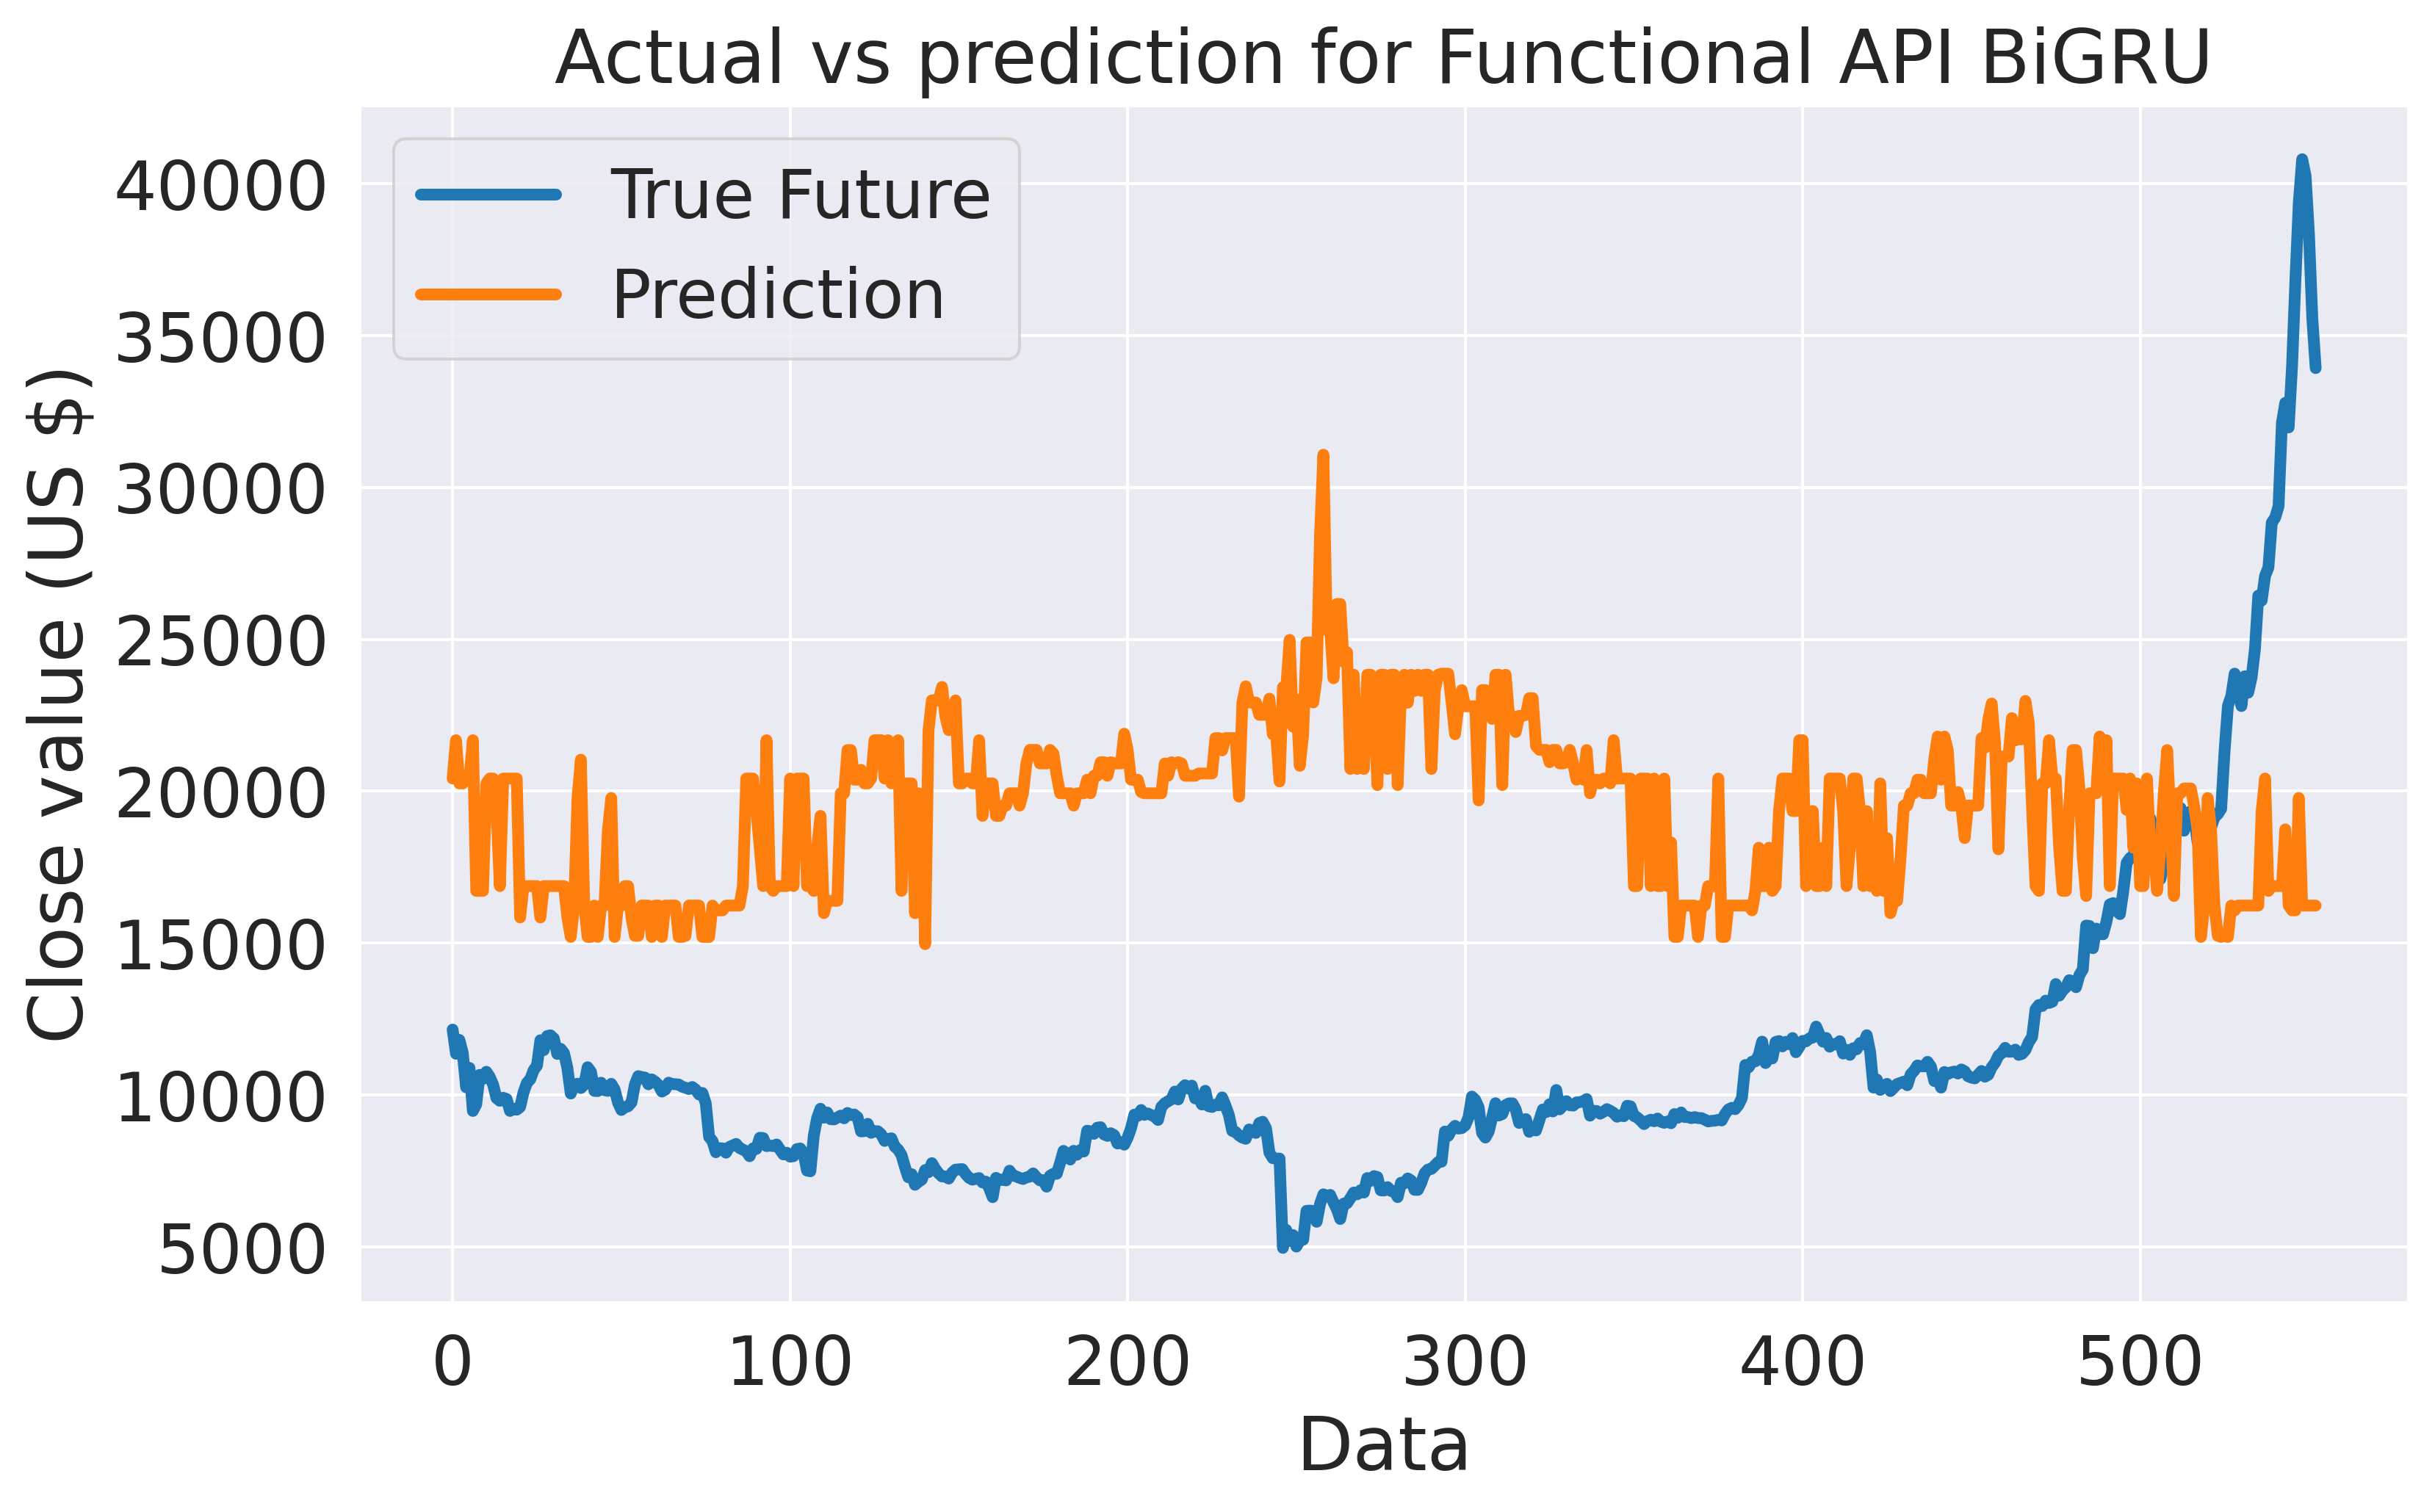

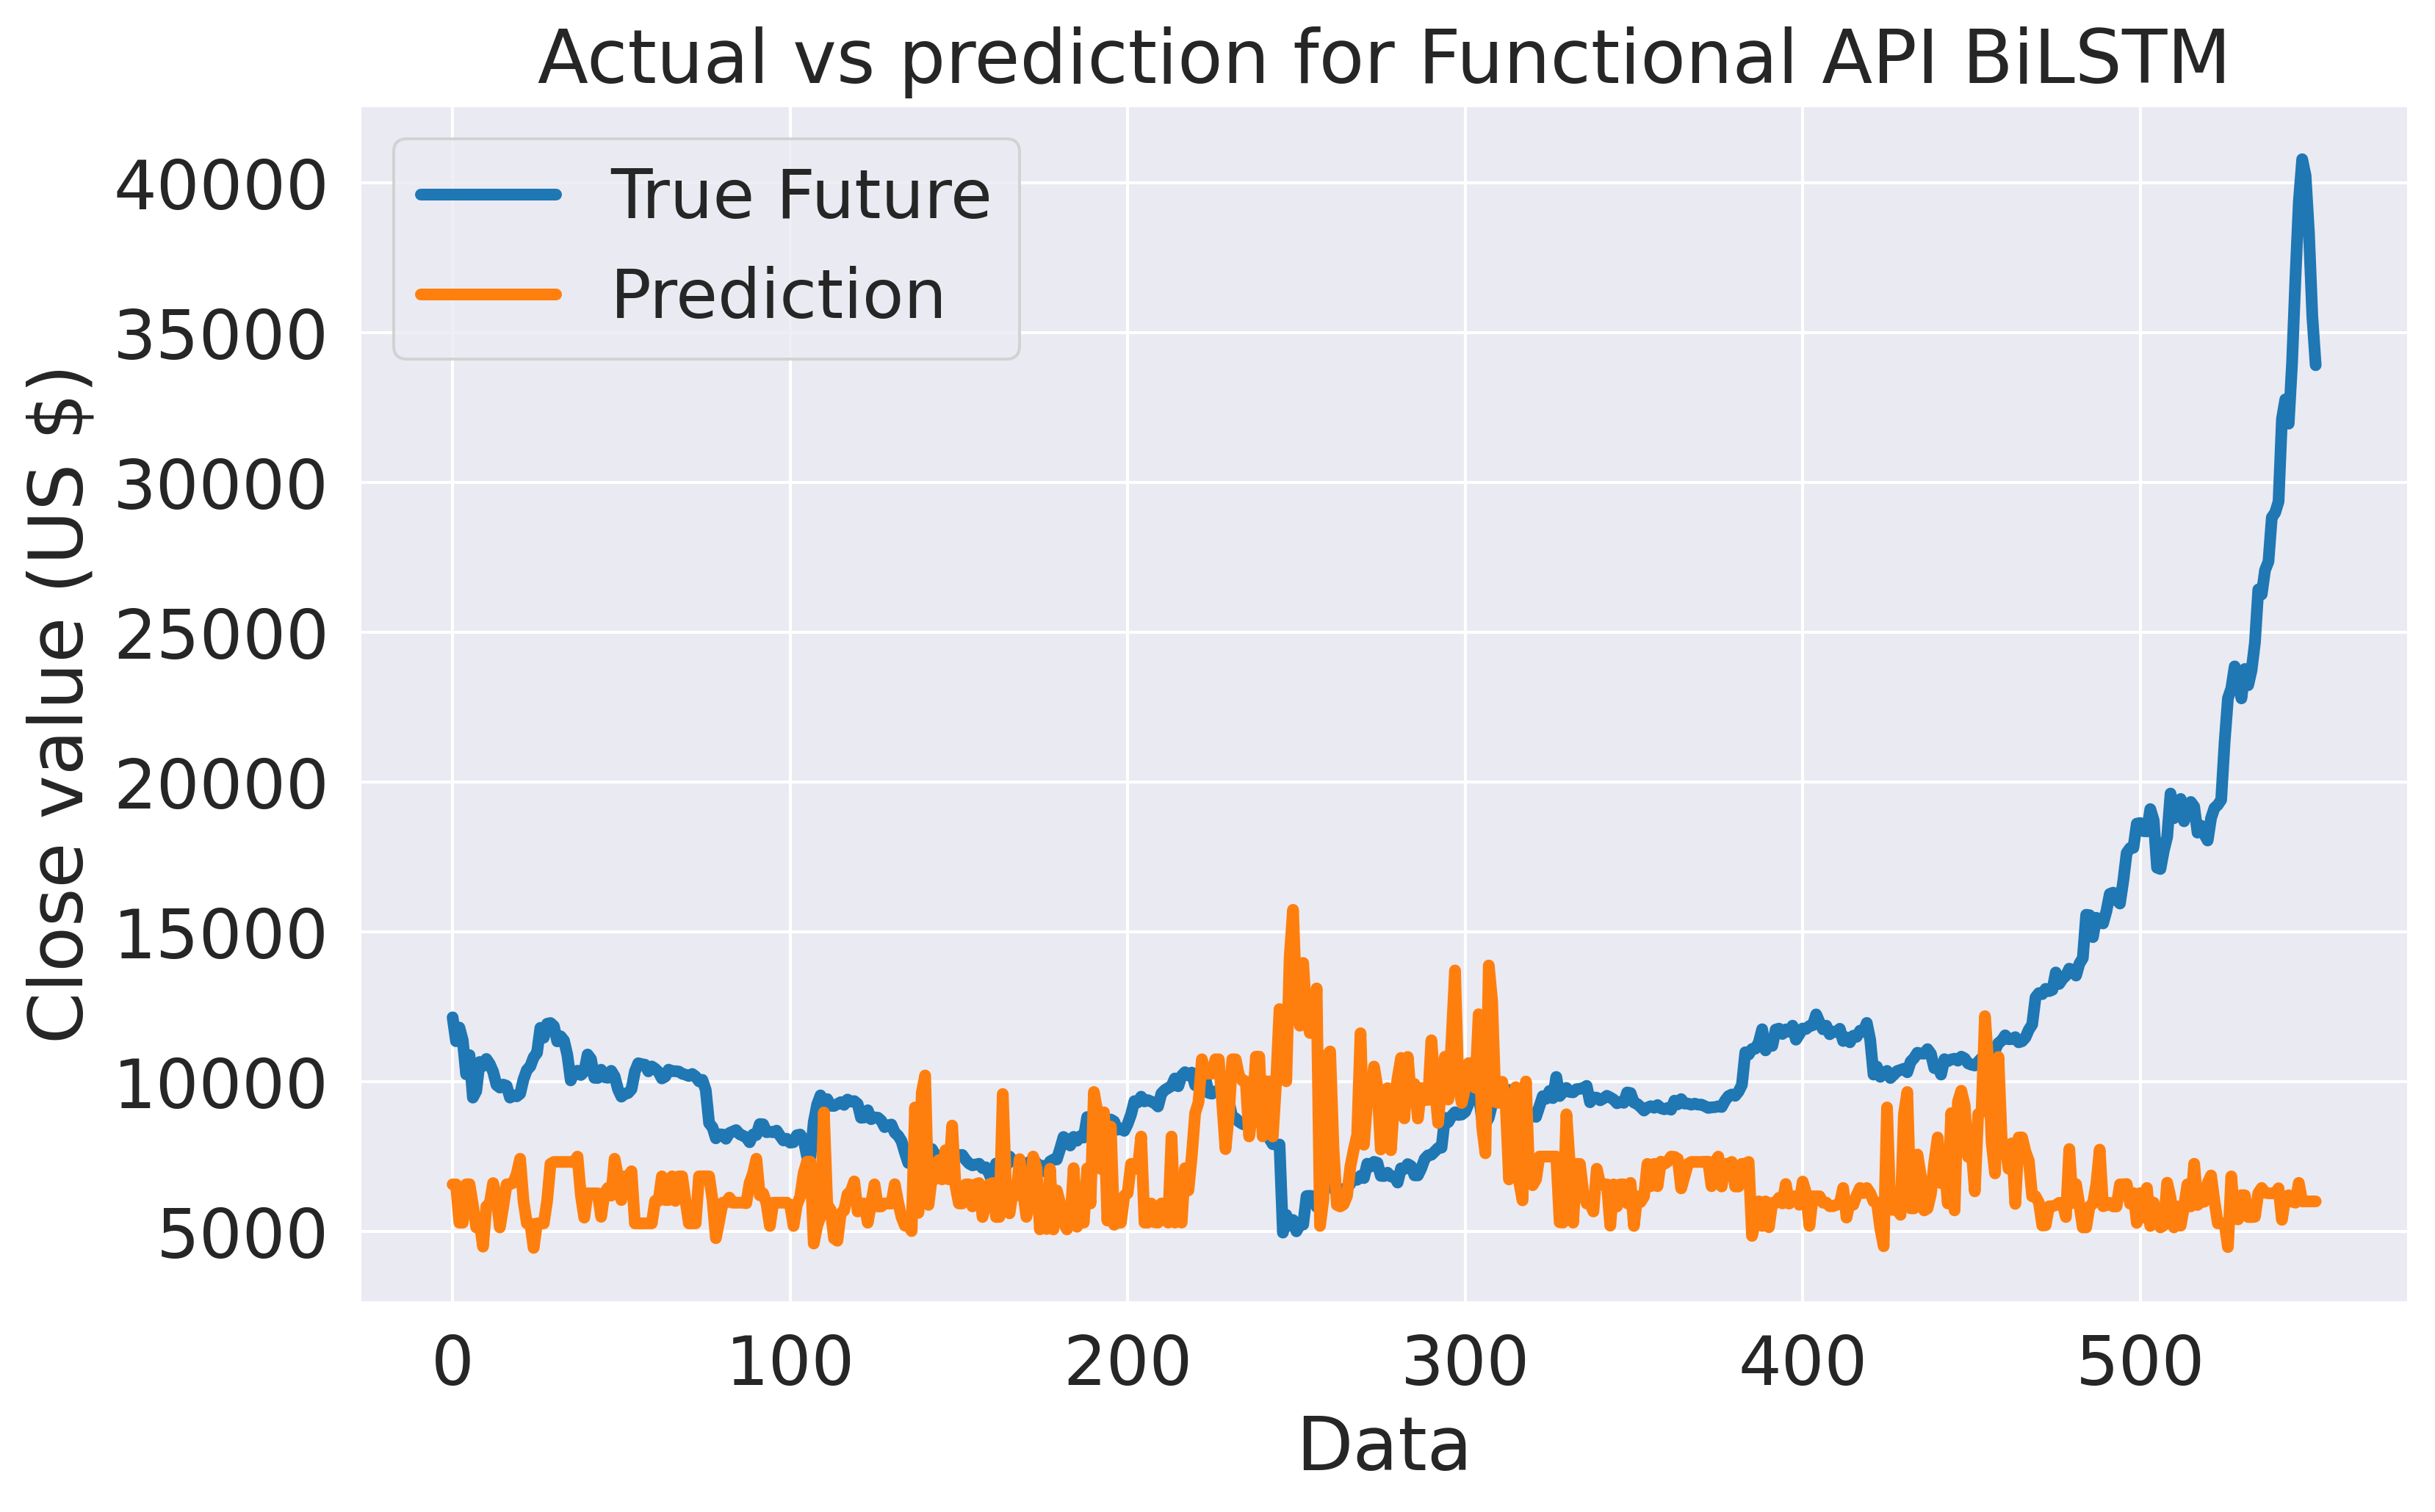

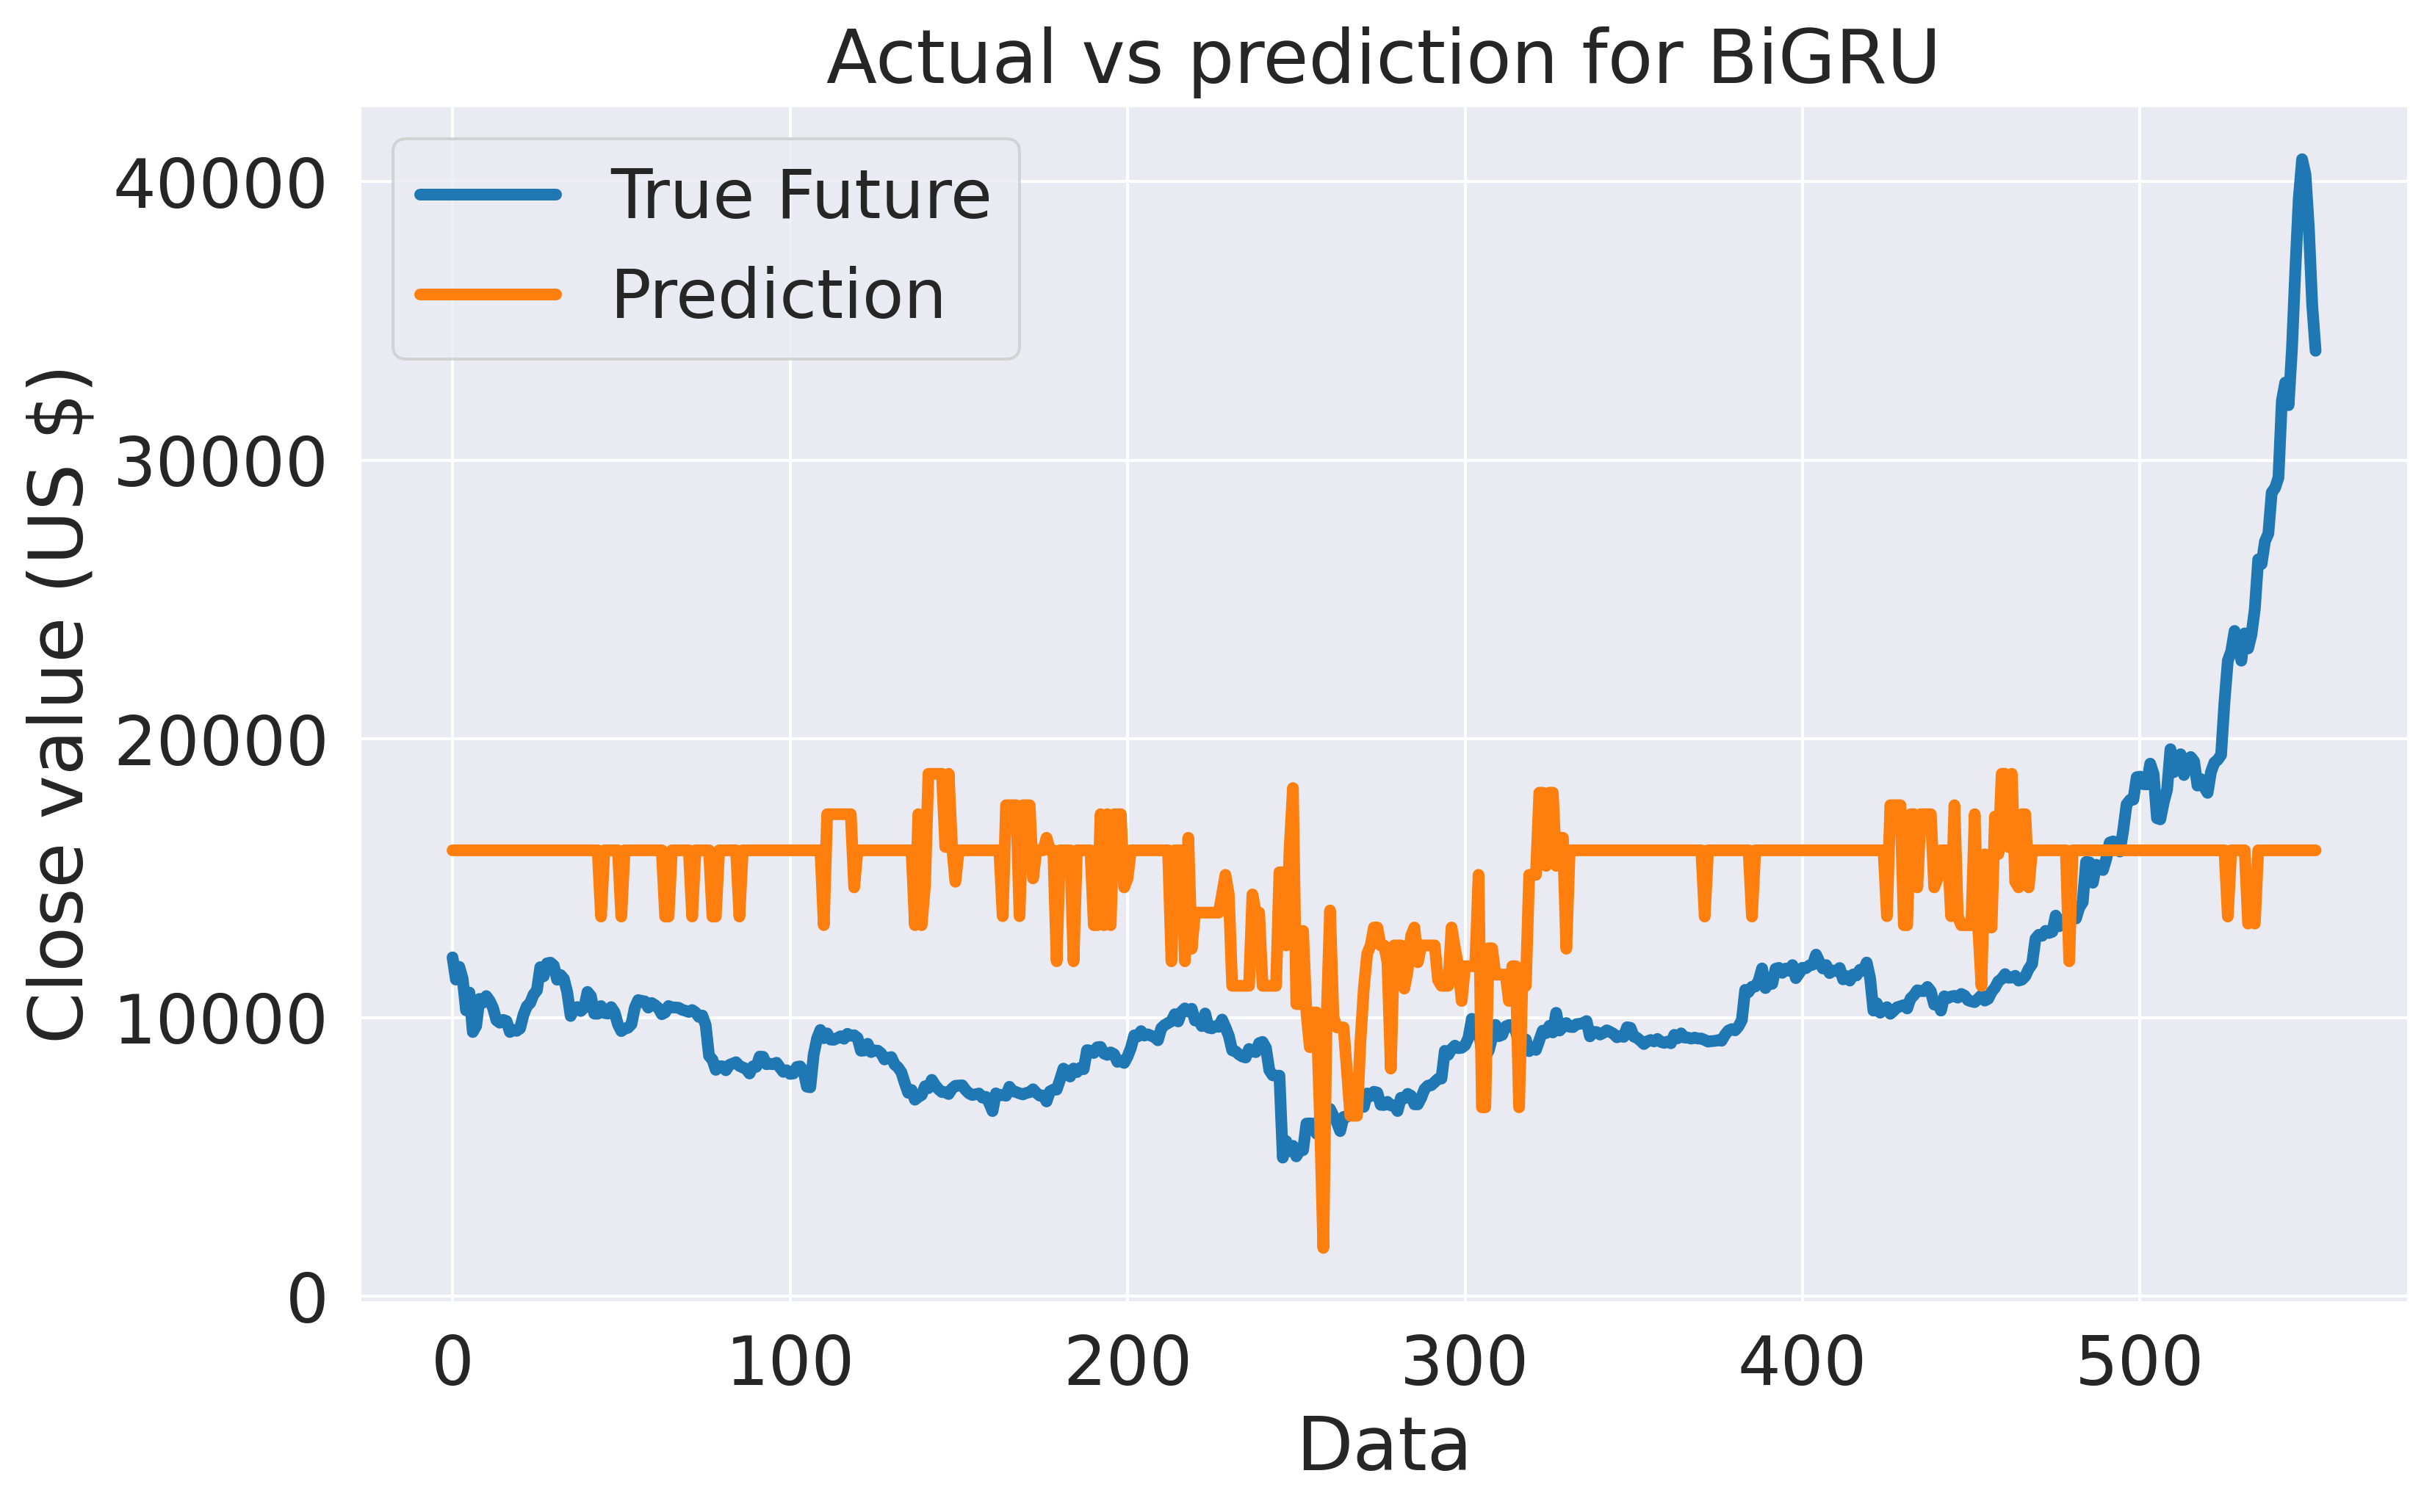

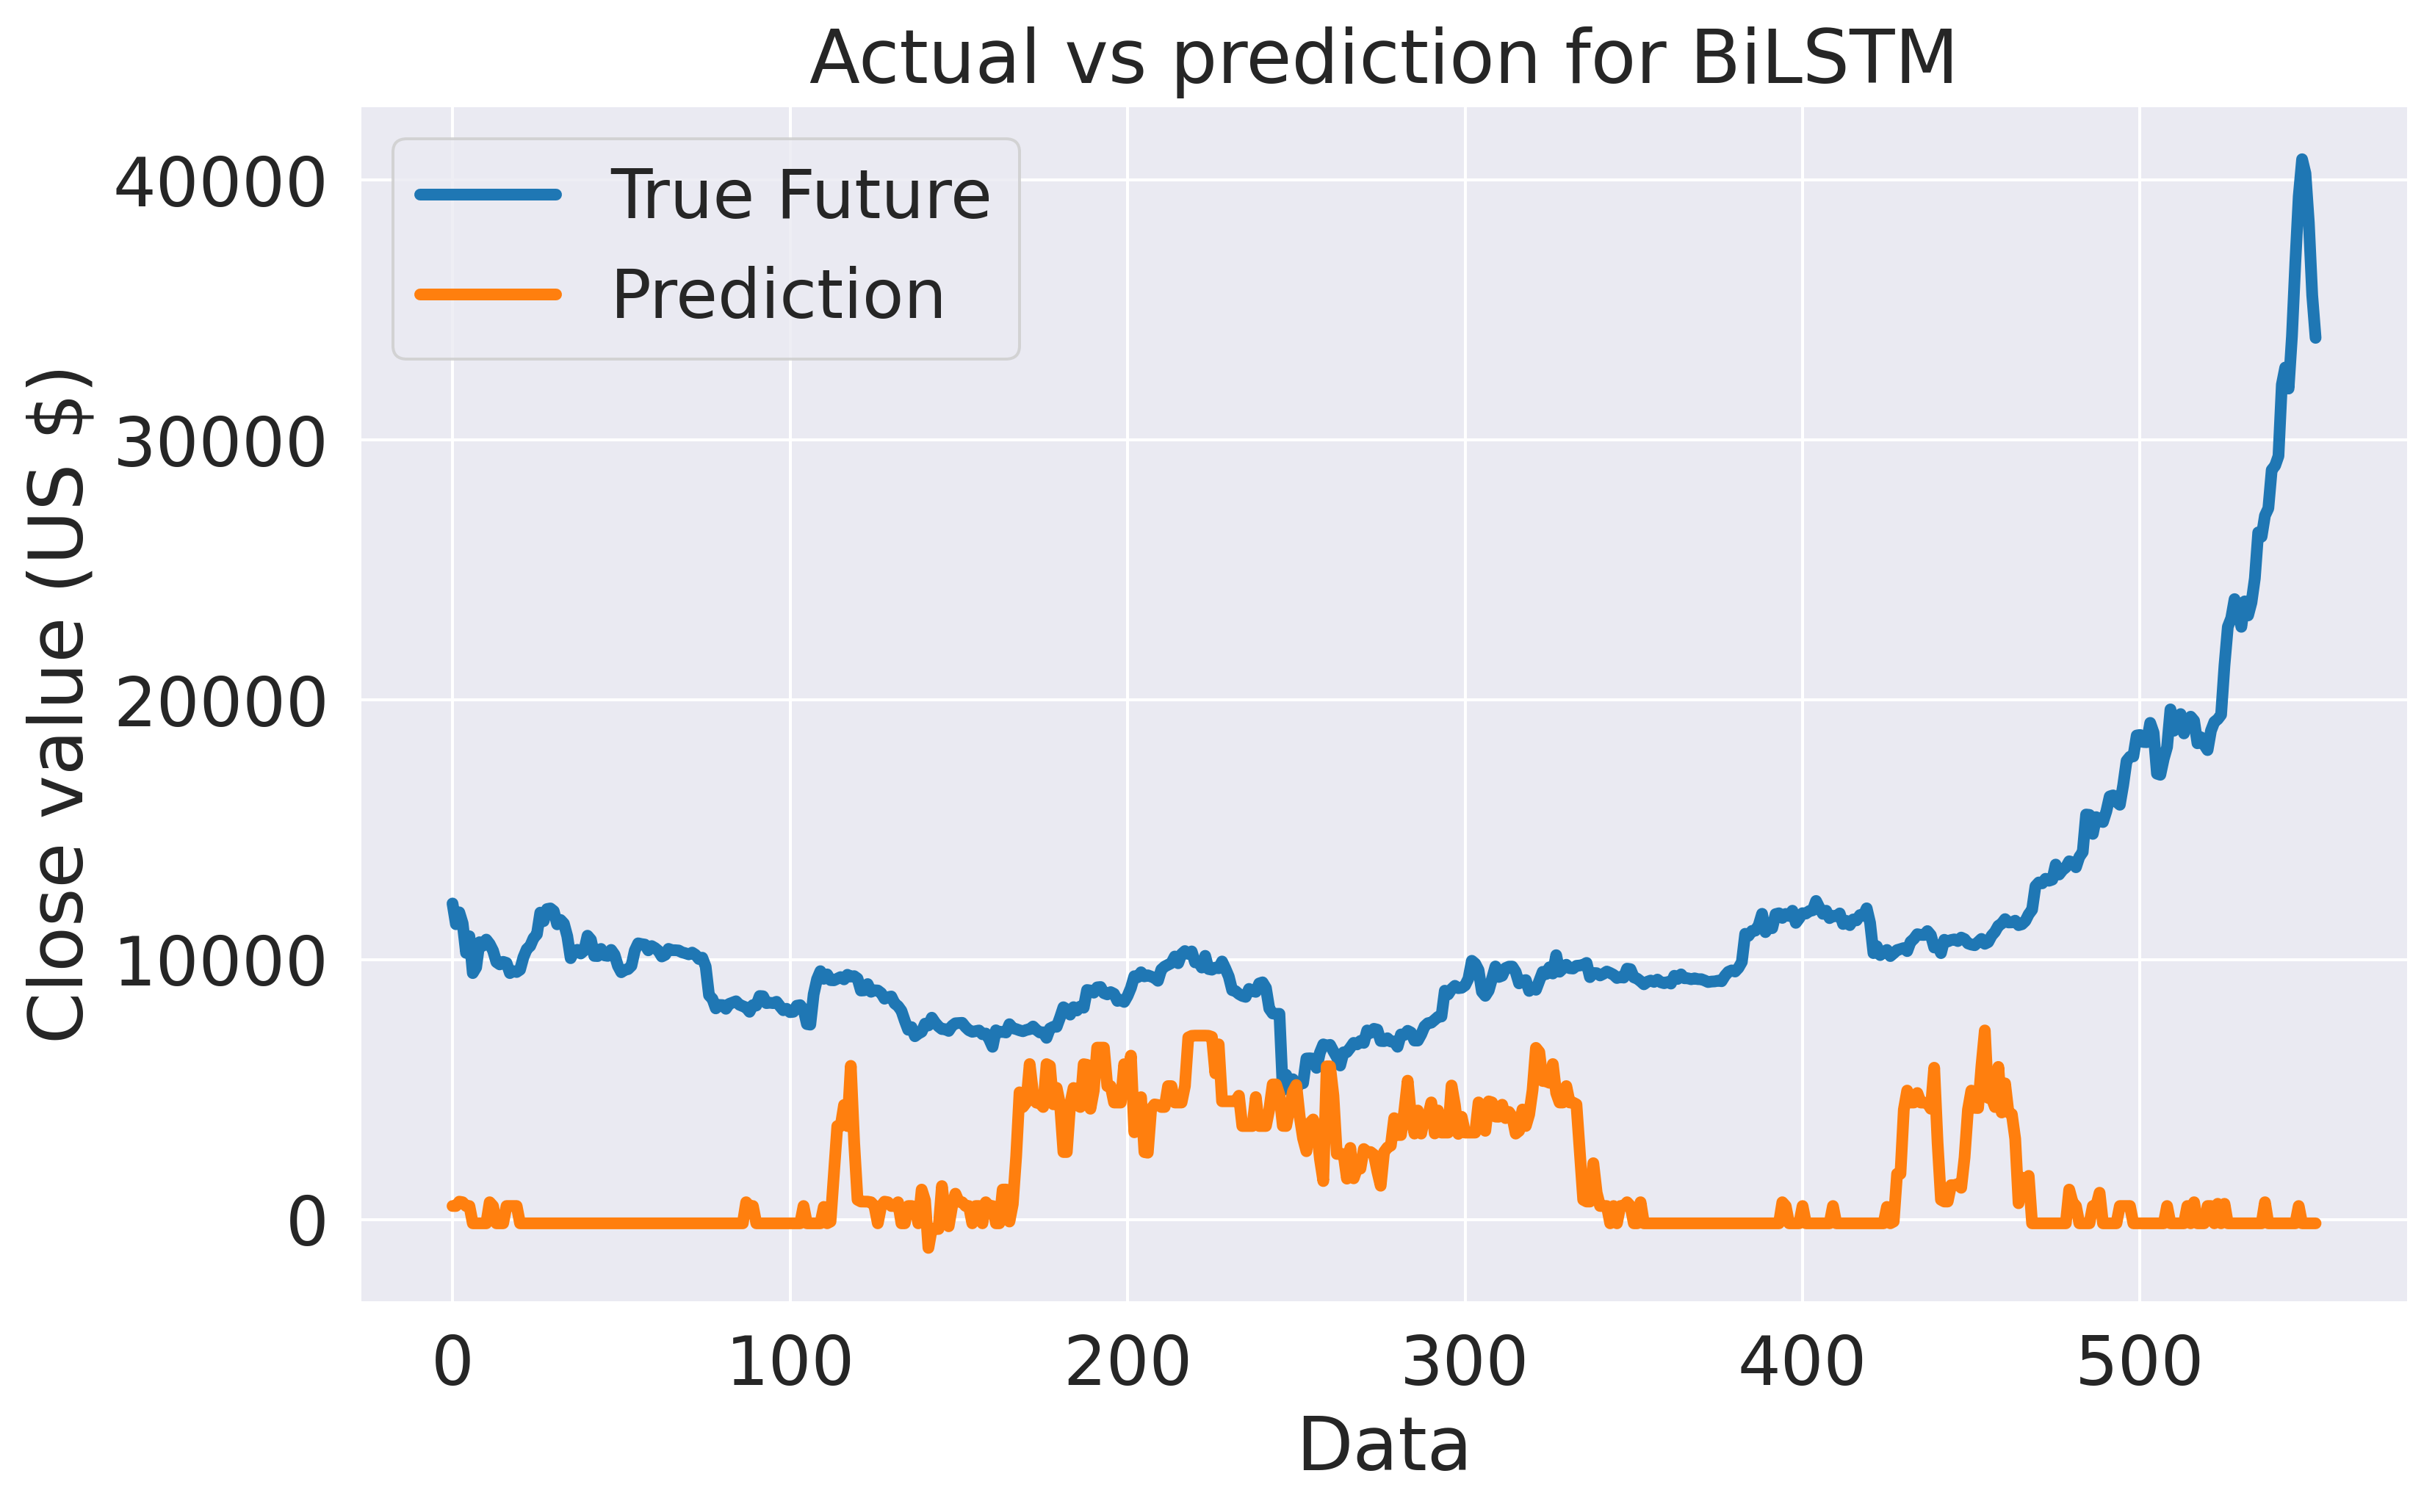

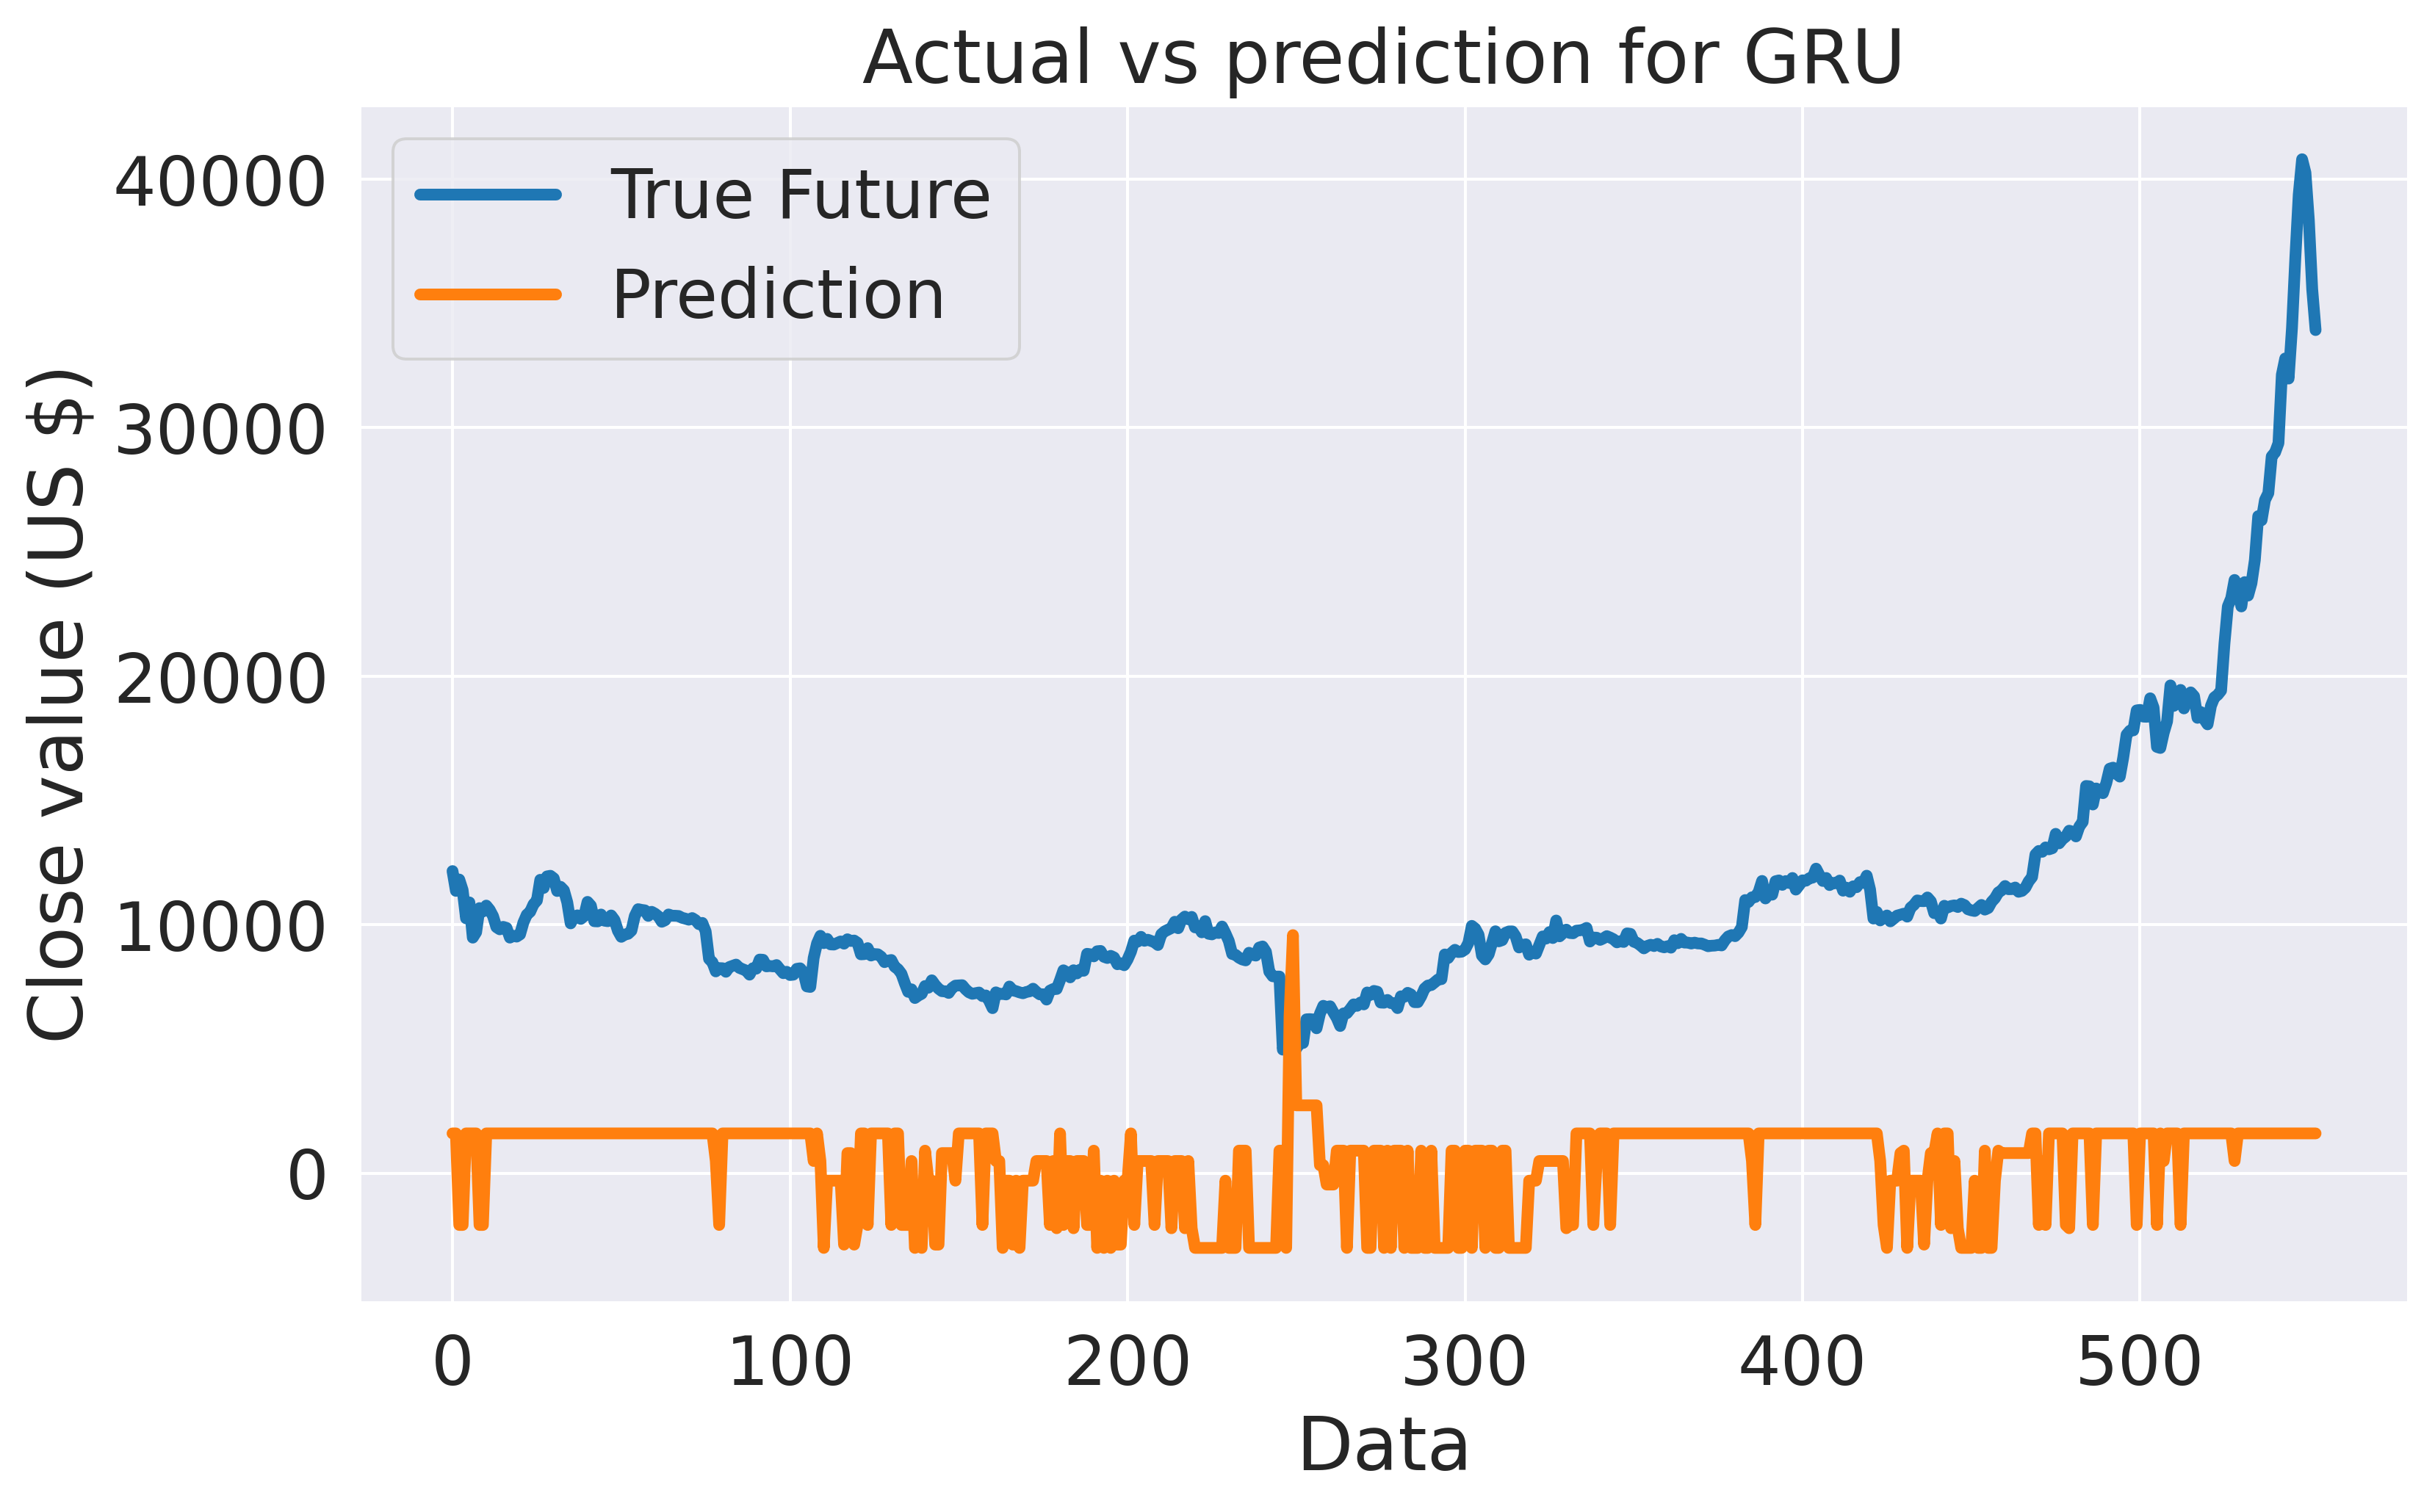

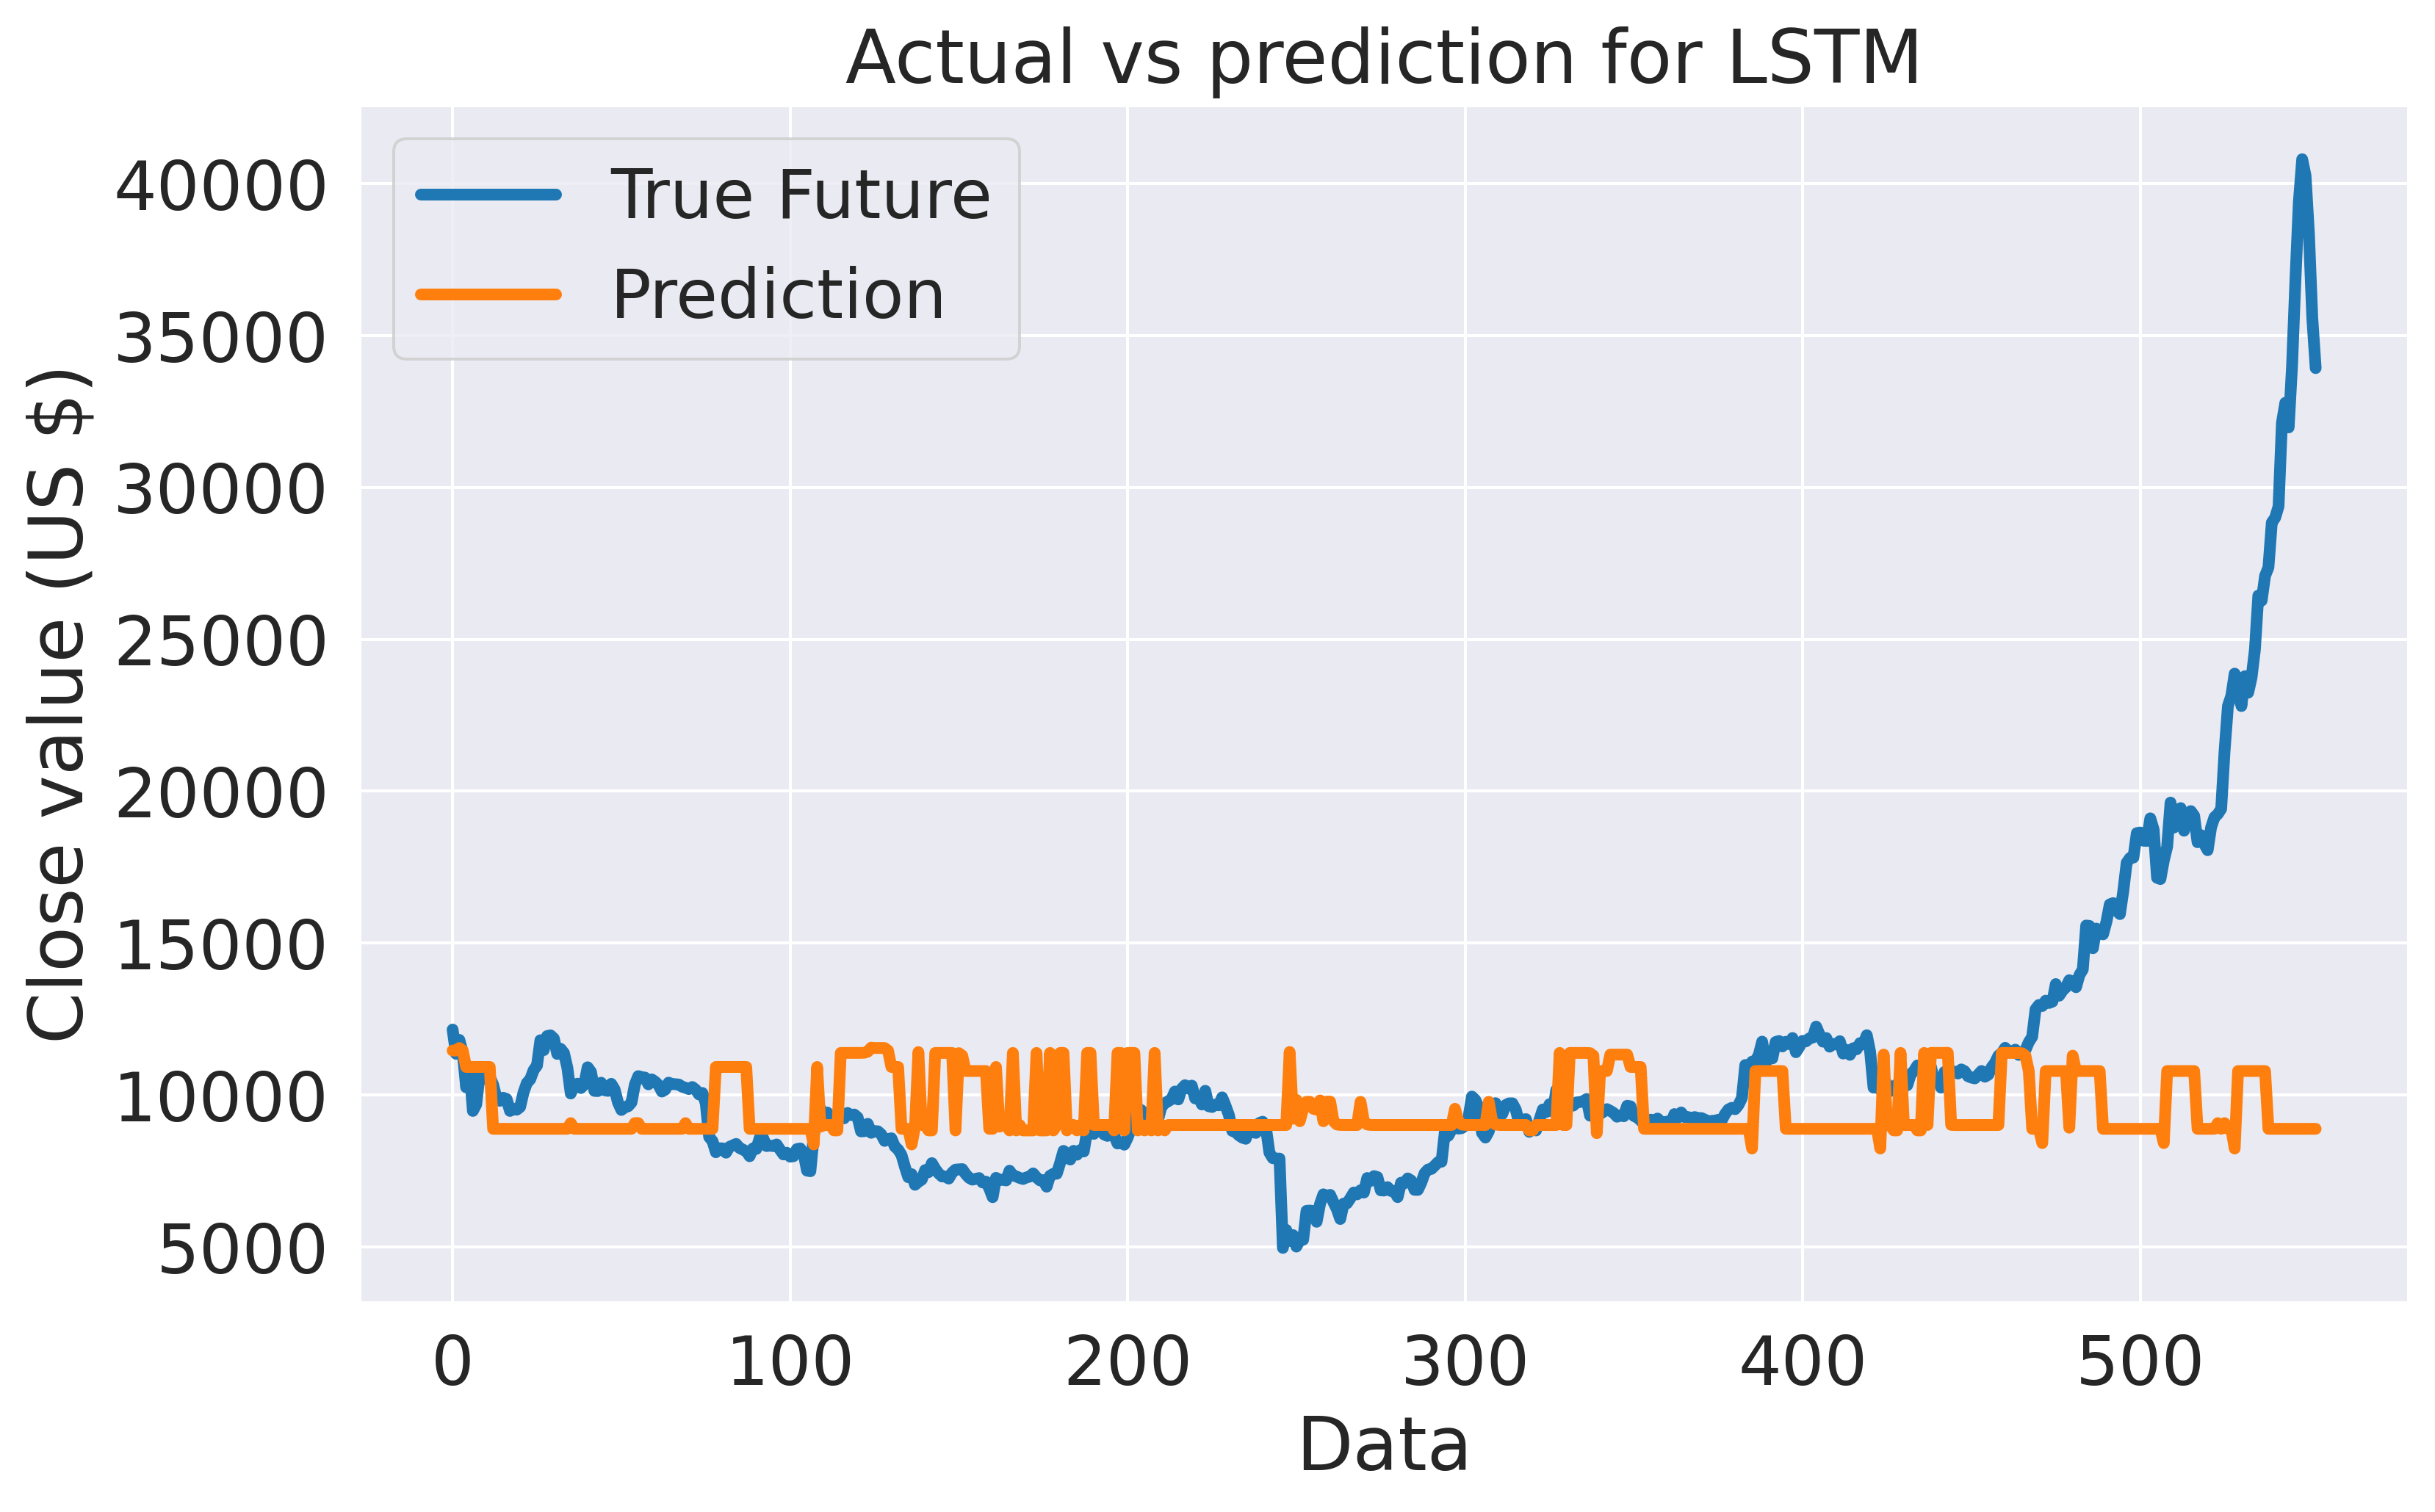

In [ ]:
def plot_prediction(prediction, model_type, y_test):

    plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    range_future = len(prediction)


    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Actual vs prediction for ' + model_type)
    plt.legend(loc='upper left')
    plt.xlabel('Data')
    plt.ylabel('Close value (US $)')


plot_prediction(predicted_parallel_biGru, 'Functional API BiGRU', y_test)
plot_prediction(predicted_parallel_biLstm, 'Functional API BiLSTM', y_test)

plot_prediction(predicted_sequential_biGru, 'BiGRU', y_test)
plot_prediction(predicted_sequential_biLstm, 'BiLSTM', y_test)

plot_prediction(predicted_sequential_Gru, 'GRU', y_test)
plot_prediction(predicted_sequential_Lstm, 'LSTM', y_test)

In [ ]:
def prediction_perfomance(predicted_values, actual_values, model_type):
    errors = predicted_values - actual_values
    mse = np.square(errors).mean()

    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    print(model_type + ':')
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('Mean Percentage Error: {:.2f}'.format(mape))
    print("\n")



prediction_perfomance(predicted_parallel_biGru, y_test, 'Func Bidirectional GRU')
prediction_perfomance(predicted_parallel_biLstm, y_test, 'Func Bidirectional LSTM')

prediction_perfomance(predicted_sequential_biGru, y_test, 'Bidirectional GRU')
prediction_perfomance(predicted_sequential_biLstm, y_test, 'Bidirectional LSTM')

prediction_perfomance(predicted_sequential_Gru, y_test, 'GRU')
prediction_perfomance(predicted_sequential_Lstm, y_test, 'LSTM')

"""
corr_matrix = np.corrcoef(y_test, prediction_func_bilstm)
corr = corr_matrix[0,1]
R_sq = corr**2

print(R_sq)
"""

Func Bidirectional GRU:
Mean Absolute Error: 9941.14
Root Mean Square Error: 10819.41
Mean Percentage Error: 109.10


Func Bidirectional LSTM:
Mean Absolute Error: 4796.22
Root Mean Square Error: 7185.76
Mean Percentage Error: 37.78


Bidirectional GRU:
Mean Absolute Error: 5831.89
Root Mean Square Error: 6645.92
Mean Percentage Error: 59.70


Bidirectional LSTM:
Mean Absolute Error: 9371.98
Root Mean Square Error: 11269.69
Mean Percentage Error: 80.96


GRU:
Mean Absolute Error: 10592.95
Root Mean Square Error: 11761.38
Mean Percentage Error: 96.88


LSTM:
Mean Absolute Error: 2981.59
Root Mean Square Error: 5534.93
Mean Percentage Error: 22.41




'\ncorr_matrix = np.corrcoef(y_test, prediction_func_bilstm)\ncorr = corr_matrix[0,1]\nR_sq = corr**2\n \nprint(R_sq)\n'

In [ ]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.

gruModel.save("saved_data/gruModel")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("biLstmModel_total_units")


INFO:tensorflow:Assets written to: saved_data/gruModel/assets


INFO:tensorflow:Assets written to: saved_data/gruModel/assets


In [ ]:
!ls saved_data

biGruModel.png	 func_biGruModel.png   gruModel      lstmModel.png
biLstmModel.png  func_biLstmModel.png  gruModel.png  training.log


In [ ]:
new_model = tf.keras.models.load_model('saved_data/gruModel')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 64)                13632     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
'''
from google.colab.patches import cv2_imshow # for image display

cv2_imshow('saved_data/func_biGruModel.png')
cv2_imshow('saved_data/func_biLstmModel.png')
cv2_imshow('saved_data/biGruModel.png')
cv2_imshow('saved_data/biLstmModel.png')
cv2_imshow('saved_data/gruModel.png')
cv2_imshow('saved_data/lstmModel.png')
'''

"\nfrom google.colab.patches import cv2_imshow # for image display\n\ncv2_imshow('saved_data/func_biGruModel.png')\ncv2_imshow('saved_data/func_biLstmModel.png')\ncv2_imshow('saved_data/biGruModel.png')\ncv2_imshow('saved_data/biLstmModel.png')\ncv2_imshow('saved_data/gruModel.png')\ncv2_imshow('saved_data/lstmModel.png')\n"

In [ ]:
from tabulate import tabulate

d = [ ["Parallel Bidirectional - GRU", 5.97,	5.69,	7.77 ],
     ["Parallel Bidirectional - LSTM", 8.59,	6.96,	8.93],
     ["Bidirectional - GRU", 6.49,	5.55,	8.48],
     ["Bidirectional - LSTM", 8.12,	6.99,	12.01 ],
     ["GRU", 5.78,	7.58,	7.52],
     ["LSTM", 7.83,	8.55,	9.35]]

print(tabulate(d, headers=["Model", "MAPE(1-layer)", "MAPE(2-layer)", "MAPE(3-layer)"]))


Model                            MAPE(1-layer)    MAPE(2-layer)    MAPE(3-layer)
-----------------------------  ---------------  ---------------  ---------------
Parallel Bidirectional - GRU              5.97             5.69             7.77
Parallel Bidirectional - LSTM             8.59             6.96             8.93
Bidirectional - GRU                       6.49             5.55             8.48
Bidirectional - LSTM                      8.12             6.99            12.01
GRU                                       5.78             7.58             7.52
LSTM                                      7.83             8.55             9.35


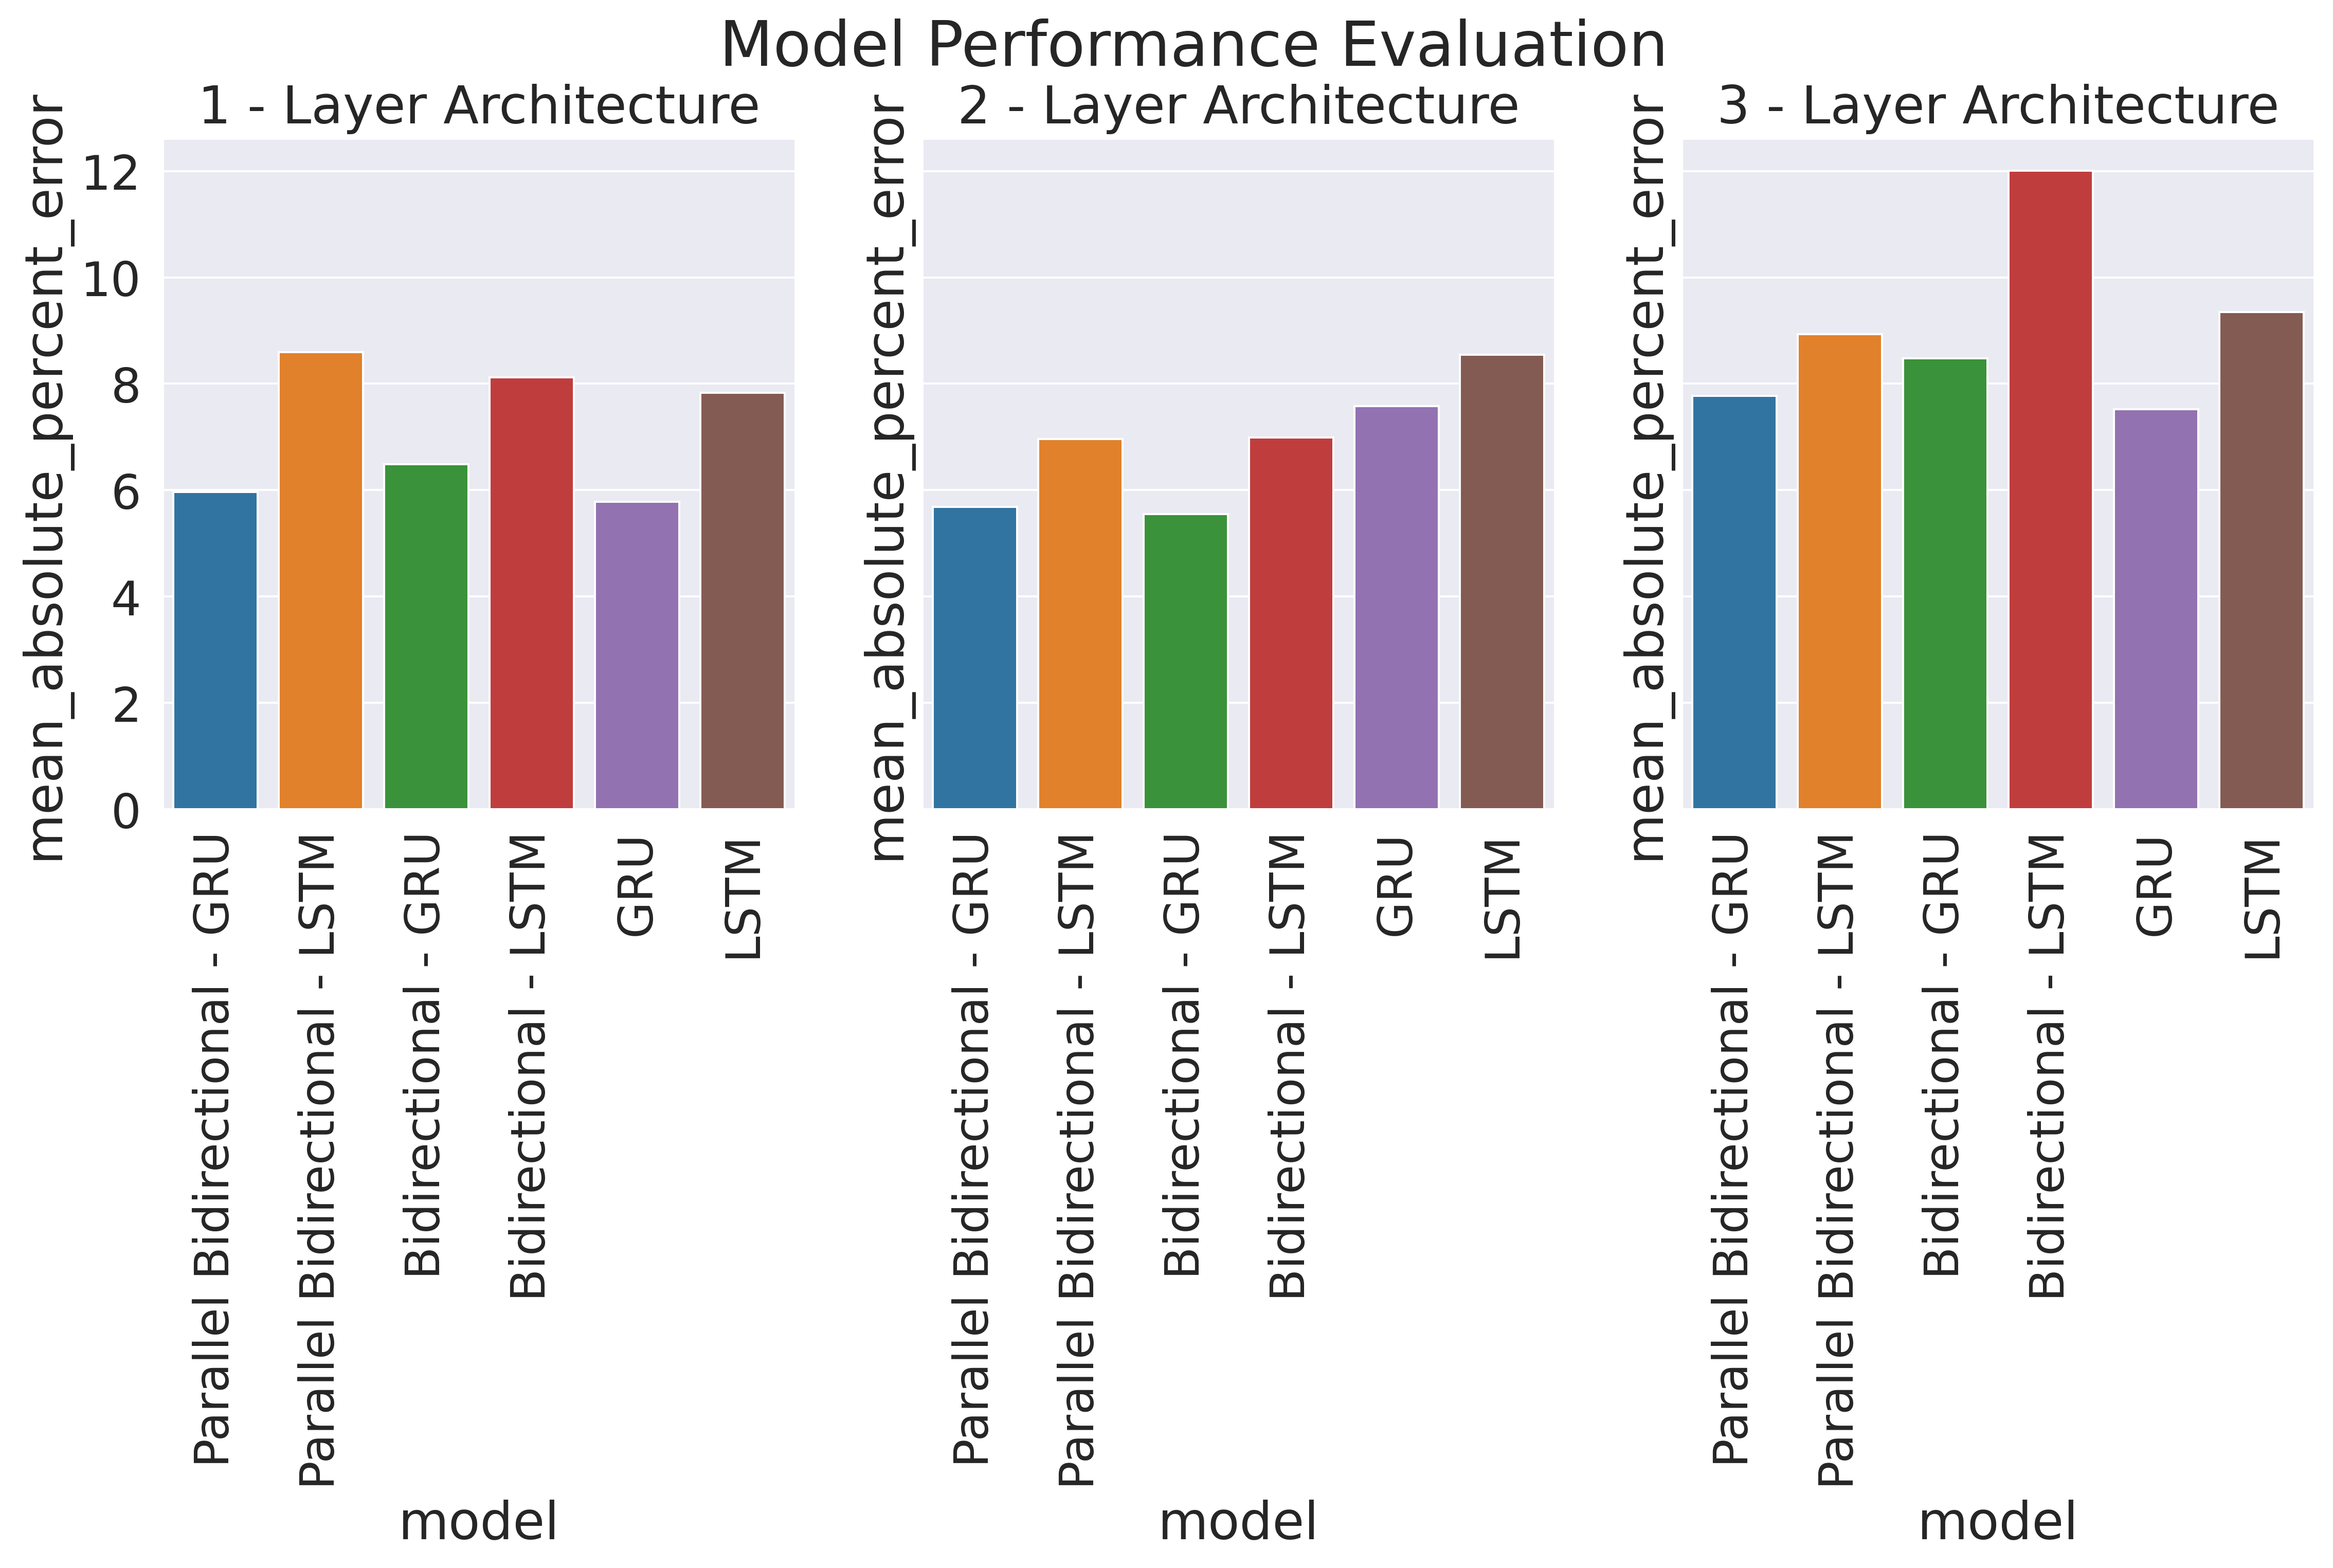

In [ ]:
performance_data = {'architecture': ['1 - Layer', '2 - Layer', '3 - Layer', '1 - Layer', '2 - Layer', '3 - Layer', '1 - Layer', '2 - Layer', '3 - Layer','1 - Layer', '2 - Layer', '3 - Layer', '1 - Layer', '2 - Layer', '3 - Layer', '1 - Layer', '2 - Layer', '3 - Layer'],
     'model': ["Parallel Bidirectional - GRU","Parallel Bidirectional - GRU","Parallel Bidirectional - GRU", "Parallel Bidirectional - LSTM", "Parallel Bidirectional - LSTM","Parallel Bidirectional - LSTM","Bidirectional - GRU","Bidirectional - GRU","Bidirectional - GRU","Bidirectional - LSTM","Bidirectional - LSTM","Bidirectional - LSTM", "GRU","GRU","GRU", "LSTM", "LSTM", "LSTM"],
     'mean_absolute_percent_error':[5.97,	5.69,	7.77,
8.59,	6.96,	8.93,
6.49,	5.55,	8.48,
8.12,	6.99,	12.01,
5.78,	7.58,	7.52,
7.83,	8.55,	9.35]}

dfp = pd.DataFrame(data=performance_data)
data_sns = dfp.set_index('architecture')

layer_1 = data_sns.loc[ '1 - Layer' ]
layer_2 = data_sns.loc['2 - Layer']
layer_3 = data_sns.loc['3 - Layer']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Model Performance Evaluation ')


# Layer_1
sns.barplot(ax=axes[0], x=layer_1.model, y=layer_1.mean_absolute_percent_error)
axes[0].set_title('1 - Layer Architecture')
axes[0].tick_params(axis='x', labelrotation=90)


# Layer_2
sns.barplot(ax=axes[1], x=layer_2.model, y=layer_2.mean_absolute_percent_error)
axes[1].set_title('2 - Layer Architecture')
axes[1].tick_params(axis='x', labelrotation=90)


# Layer_3
sns.barplot(ax=axes[2], x=layer_3.model, y=layer_3.mean_absolute_percent_error)
axes[2].set_title('3 - Layer Architecture')
axes[2].tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(top=0.85)

Text(0.5, 1.0, 'Performance Evaluation for Individual Model')

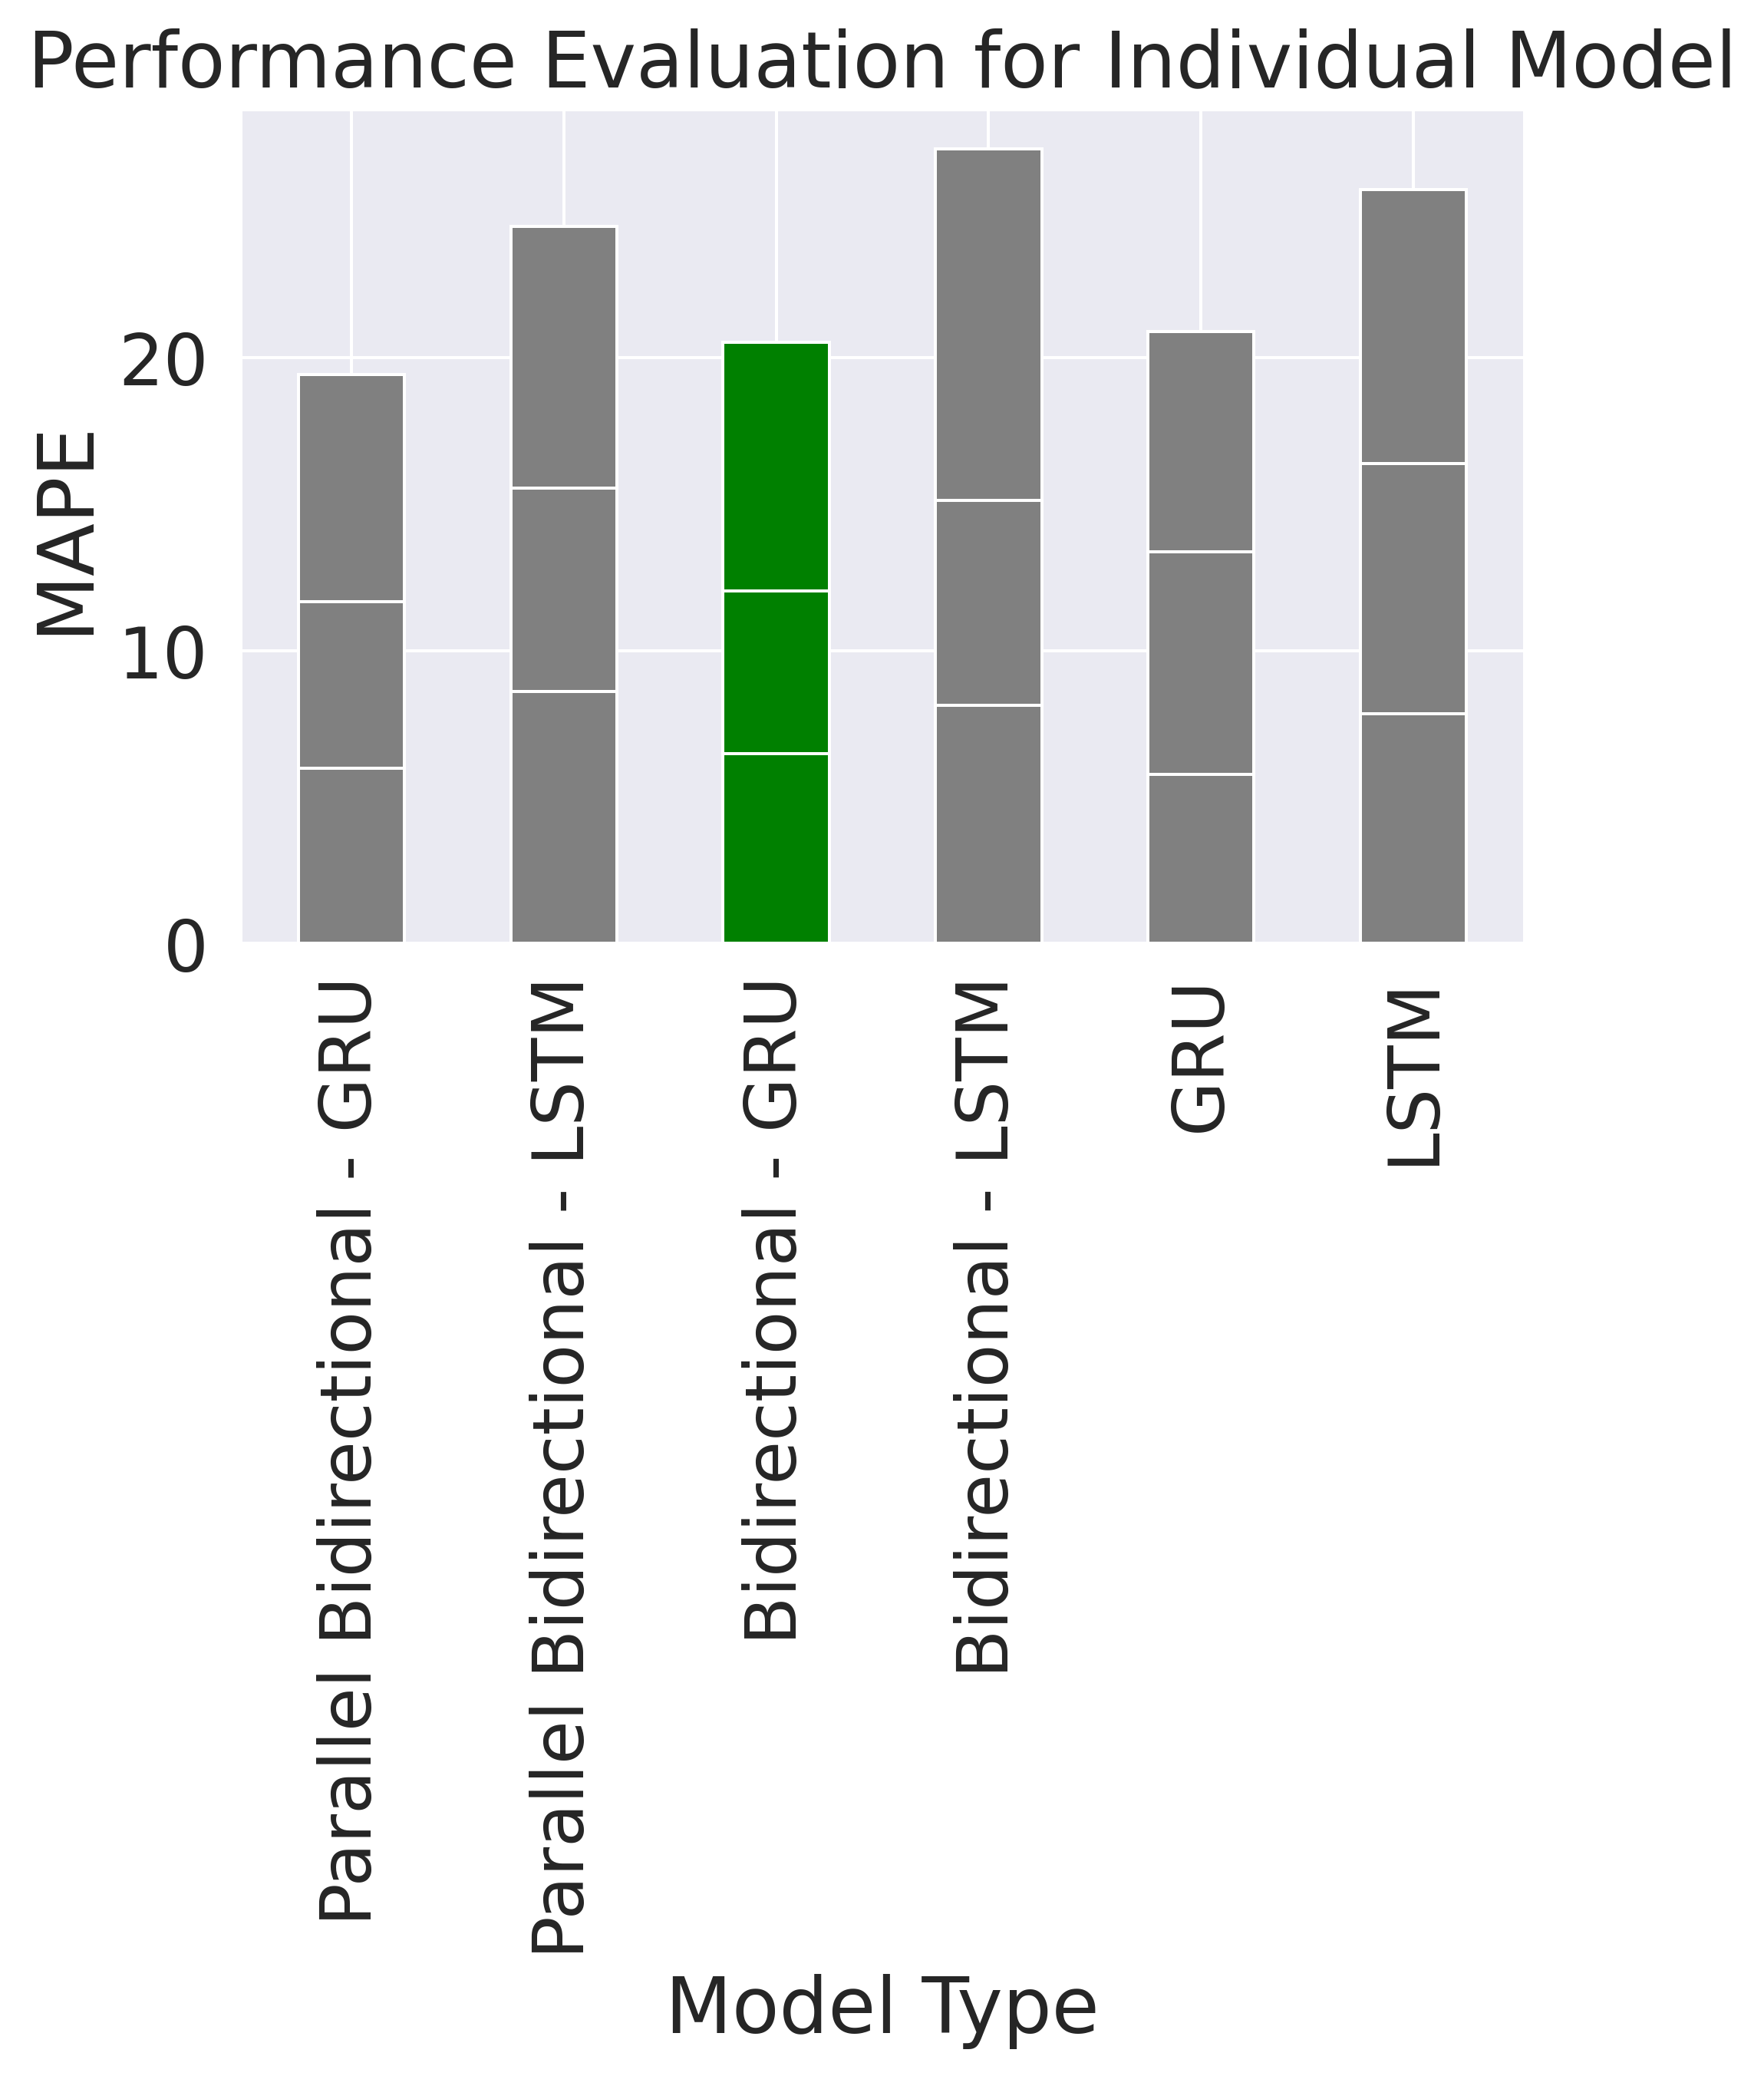

In [ ]:
import itertools

x = ('Parallel Bidirectional - GRU', 'Parallel Bidirectional - LSTM', 'Bidirectional - GRU','Bidirectional - LSTM', 'GRU', 'LSTM')
data = [[5.97,	5.69,	7.77 ],
     [8.59,	6.96,	8.93],
     [6.49,	5.55,	8.48],
     [8.12,	6.99,	12.01],
     [5.78,	7.58,	7.52],
     [7.83,	8.55,	9.35]]

width = .5
plts = []
colors = ['r','g','b']

for i,order in enumerate(data):
    bottom_counter = 0
    loc_plts = []
    for o,c in zip(order,itertools.cycle(colors)):
        if i==2:
          tmp_plt = plt.bar(i, o, width, color='green', bottom=bottom_counter)
        else:
          tmp_plt = plt.bar(i, o, width, color='grey', bottom=bottom_counter)
        loc_plts.append(tmp_plt)
        bottom_counter+=o
    plts.append(loc_plts)


plt.xticks(np.arange(6), x, rotation ='vertical')
plt.xlabel("Model Type")
plt.ylabel("MAPE")
plt.title("Performance Evaluation for Individual Model")